In [2]:
# ============================================================
# Tail-Patch 8 方法 × Top-{1,10,20}
#  - 包含 plateau-stop 版本 (DE_fixed_stop, DE_seq_stop)
# ============================================================

!pip -q install datasets transformers scipy tqdm --upgrade


In [6]:
# ================================================================
#  Tail-Patch Attack: 8 methods × {Top-1, Top-10, Top-20}
#  – corpus 1000 docs , 100 queries  (BeIR/scifact)
#  – BERT-base-uncased encoder
#  – VRAM-friendly (batch=16, CLS 立即搬 CPU, 每輪 empty_cache)
# ================================================================


import os, random, math, tqdm, warnings, numpy as np, pandas as pd, torch
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
from scipy.optimize import differential_evolution

warnings.filterwarnings("ignore")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
N_DOCS     = 1_000
N_Q        = 100
TAIL_L     = 5          # 固定補丁長度
BUDGET     = 150        # 固定 f-eval / epoch
PATIENCE   = 20         # plateau 20 代早停
BATCH_CLS  = 16         # CLS 批次，愈小愈省顯存

# ---------------------------------------------------------------
def cos_row(x, Y):
    return torch.nn.functional.cosine_similarity(
        x.expand_as(Y.to(x.device)), Y.to(x.device), dim=1)

def dcg(rank): return 1 / math.log2(rank + 1)

def load_subset():
    c = load_dataset("BeIR/scifact", "corpus",  split="corpus")
    q = load_dataset("BeIR/scifact", "queries", split="queries")
    docs = random.sample(list(c), N_DOCS)
    qs   = random.sample(list(q), N_Q)
    return [d["text"] for d in docs], [x["text"] for x in qs]

# -------------------- GGPP (完整) -------------------------------
def ggpp_full(tok, bert, ids, msk, CP, tgt_cls, tgt_txt,
              cap_L=5, max_epoch=150, topk_loss=20):
    body = tok(tgt_txt, add_special_tokens=False,
               truncation=True, max_length=510)["input_ids"]
    body += [tok.unk_token_id] * max(0, cap_L - len(body))

    base = bert(**tok(tgt_txt, return_tensors="pt",
                      truncation=True, max_length=512).to(DEVICE)
               ).last_hidden_state[0, 0]
    imp = []
    for i in range(cap_L):
        tmp = body.copy(); tmp[i] = tok.mask_token_id
        tens = torch.tensor([tok.cls_token_id]+tmp+[tok.sep_token_id]
                           ).unsqueeze(0).to(DEVICE)
        emb = bert(input_ids=tens,
                   attention_mask=torch.ones_like(tens)).last_hidden_state[0, 0]
        imp.append(1 - torch.nn.functional.cosine_similarity(base, emb, dim=0).item())
    prefix = [body[i] for i in np.argsort(imp)[-cap_L:]]

    pos   = list(range(502, 502+cap_L))
    patch = ids.clone()
    for p, v in zip(pos, prefix): patch[p] = v
    am = msk.clone(); am[pos] = 1
    W  = bert.embeddings.word_embeddings.weight

  
    # ★ loss_fn 回傳 Tensor
    def loss_fn(cls_vec):
        kth=torch.topk(cos_row(cls_vec,CP),topk_loss).values[-1]
        sim=torch.nn.functional.cosine_similarity(cls_vec,tgt_cls)[0]
        return torch.relu(kth-sim)

    best_cls=bert(input_ids=patch.unsqueeze(0),
                  attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
    best_loss=loss_fn(best_cls).item(); used_iter=0

    for _ in range(max_epoch):
        used_iter+=1
        emb=bert.embeddings.word_embeddings(
            patch.unsqueeze(0)).detach().clone().requires_grad_(True)
        cls=bert(inputs_embeds=emb,
                 attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
        loss=loss_fn(cls); loss.backward()
        if loss.item()==0: best_cls=cls; break
        grad=emb.grad[0,pos]; score=torch.matmul(grad,W.t())
        cand_ids=score.topk(5,largest=False,dim=1).indices.cpu()
        improved=False
        for mask in range(1,1<<cap_L):
            cand=patch.clone()
            for i in range(cap_L):
                if mask&(1<<i): cand[pos[i]]=random.choice(cand_ids[i]).item()
            cls2=bert(input_ids=cand.unsqueeze(0),
                      attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
            l2=loss_fn(cls2).item()
            if l2<best_loss:
                best_loss=l2; patch=cand; best_cls=cls2; improved=True
            if l2==0: break
        if not improved: break
    return best_cls,cap_L,used_iter
# -------------------------------------------
# ---------------------------------------------------------------

def run_all(topk_loss, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    tok  = BertTokenizer.from_pretrained("bert-base-uncased")
    bert = BertModel.from_pretrained("bert-base-uncased").eval().to(DEVICE)
    VOC  = tok.vocab_size
    def enc(t): return tok(t, padding="max_length", truncation=True,
                           max_length=512, return_tensors="pt").to(DEVICE)

    # ---------- corpus CLS (輸出立即搬 CPU) ----------
    docs, qs = load_subset()
    CLS=[]
    with torch.inference_mode():
        for i in tqdm.tqdm(range(0, len(docs), BATCH_CLS), desc="CLS"):
            bt = enc(docs[i:i+BATCH_CLS])
            cls= bert(**bt).last_hidden_state[:, 0, :].cpu()
            CLS.append(cls)
            del bt; torch.cuda.empty_cache()
    C_CLS = torch.cat(CLS)

    METHODS = ("none", "random", "greedy", "ggpp",
               "DE_fixed", "DE_seq", "DE_fixed_stop", "DE_seq_stop")
    rec=[]

    # ------------- iterate queries -------------
    for qtxt in tqdm.tqdm(qs, desc=f"Top-{topk_loss}"):
        tgt = random.randrange(len(docs))
        tgt_txt = docs[tgt]
        if len(tok(tgt_txt)["input_ids"]) > 510: continue
        tgt_cls = C_CLS[tgt:tgt+1].to(DEVICE)
        CP = C_CLS[[i for i in range(len(docs)) if i != tgt]]

        qenc = enc(qtxt); ids = qenc["input_ids"][0]; msk = qenc["attention_mask"][0]
        with torch.no_grad():
            qcls = bert(**qenc).last_hidden_state[:, 0, :]

        # -------- baseline rank --------
        base = torch.cat([
            cos_row(qcls, CP).cpu(),     # ★ 移到 CPU
            torch.nn.functional.cosine_similarity(qcls.cpu(), tgt_cls.cpu())
        ])
        rank_b = (base > base[-1]).sum().item() + 1

        for mtd in METHODS:
            success=False; used_L=0; used_iter=0; adv_cls=qcls

            # ---------- random ----------
            if mtd=="random":
                best_loss=1e9
                for _ in range(BUDGET):
                    patch=ids.clone()
                    for p in range(502, 502+TAIL_L):
                        patch[p] = random.randrange(VOC)
                    am = msk.clone(); am[502:502+TAIL_L] = 1
                    cls = bert(input_ids=patch.unsqueeze(0),
                               attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
                    kth = torch.topk(cos_row(cls, CP), topk_loss).values[-1]
                    loss= max(0., (kth - torch.nn.functional.cosine_similarity(
                                        cls, tgt_cls)[0]).item())
                    used_iter += 1
                    if loss < best_loss:
                        best_loss=loss; adv_cls=cls; success=(loss==0)
                    if success: break
                used_L=TAIL_L

            # ---------- greedy (HotFlip) ----------
            elif mtd=="greedy":
                pos=list(range(502, 502+TAIL_L)); patch=ids.clone()
                best_loss=1e9
                for _ in range(BUDGET):
                    used_iter += 1; improved=False
                    for p in pos:
                        best_id=patch[p].item()
                        for cand in random.sample(range(VOC),512):
                            patch[p]=cand
                            am = msk.clone(); am[pos]=1
                            cls=bert(input_ids=patch.unsqueeze(0),
                                     attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
                            kth=torch.topk(cos_row(cls,CP),topk_loss).values[-1]
                            loss=max(0.,(kth-torch.nn.functional.cosine_similarity(
                                              cls,tgt_cls)[0]).item())
                            if loss<best_loss:
                                best_loss=loss; best_id=cand; adv_cls=cls; improved=True
                            if loss==0: success=True; break
                        patch[p]=best_id
                        if success: break
                    if success or not improved: break
                used_L=TAIL_L

            # ---------- ggpp ----------
            elif mtd=="ggpp":
                adv_cls, used_L, used_iter = ggpp_full(
                    tok, bert, ids, msk, CP, tgt_cls, tgt_txt,
                    cap_L=TAIL_L, max_epoch=BUDGET, topk_loss=topk_loss)
                kth = torch.topk(cos_row(adv_cls, CP), topk_loss).values[-1]
                success = (kth <= torch.nn.functional.cosine_similarity(
                                      adv_cls, tgt_cls)[0])

            # ---------- DE helpers ----------
            def de_run(L, max_iter, plateau):
                pos=list(range(502, 502+L)); bounds=[(0, VOC-1)]*L
                gens = max_iter//20 if max_iter else 1000
                stop = [0]; best=[1e9]
                def obj(v):
                    v=[int(round(x)) for x in v]
                    patch=ids.clone()
                    for p,t in zip(pos,v): patch[p]=t
                    am=msk.clone(); am[pos]=1
                    cls=bert(input_ids=patch.unsqueeze(0),
                             attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
                    kth=torch.topk(cos_row(cls,CP),topk_loss).values[-1]
                    sim=torch.nn.functional.cosine_similarity(cls,tgt_cls)[0]
                    return max(0.,(kth-sim).item())
                def cb(xk,_):
                    if not plateau: return False
                    cur=obj(xk)
                    stop[0] = 0 if cur < best[0] else stop[0]+1
                    best[0] = min(best[0], cur)
                    return stop[0] >= PATIENCE or cur == 0
                res = differential_evolution(obj, bounds, popsize=20,
                                             maxiter=gens, tol=0,
                                             polish=False, seed=SEED,
                                             callback=cb)
                v=[int(round(x)) for x in res.x]
                patch=ids.clone()
                for p,t in zip(pos,v): patch[p]=t
                am=msk.clone(); am[pos]=1
                cls=bert(input_ids=patch.unsqueeze(0),
                         attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
                return cls, res.nfev, res.fun==0

            if mtd=="DE_fixed":
                adv_cls, used_iter, success = de_run(TAIL_L, BUDGET, plateau=False); used_L=TAIL_L
            if mtd=="DE_fixed_stop":
                adv_cls, used_iter, success = de_run(TAIL_L, None, plateau=True); used_L=TAIL_L
            if mtd=="DE_seq":
                for L in range(1, TAIL_L+1):
                    cls,iters,ok = de_run(L, BUDGET, plateau=False)
                    used_iter += iters
                    if ok: adv_cls=cls; used_L=L; success=True; break
                else: used_L=TAIL_L
            if mtd=="DE_seq_stop":
                for L in range(1, TAIL_L+1):
                    cls,iters,ok = de_run(L, None, plateau=True)
                    used_iter += iters
                    if ok: adv_cls=cls; used_L=L; success=True; break
                else: used_L=TAIL_L

            # ---------- metrics ----------
            sims = torch.cat([
                cos_row(adv_cls.cpu(), CP),       # ★ 移到 CPU
                torch.nn.functional.cosine_similarity(
                    adv_cls.cpu(), tgt_cls.cpu())
            ])
            rank_a = (sims > sims[-1]).sum().item() + 1
            d_mrr  = 1/rank_a - 1/rank_b
            d_ndcg = ((dcg(rank_a) if rank_a<=20 else 0) -
                      (dcg(rank_b) if rank_b<=20 else 0))
            d_cos  = (torch.nn.functional.cosine_similarity(
                        adv_cls, tgt_cls)[0] -
                      torch.nn.functional.cosine_similarity(
                        qcls, tgt_cls)[0]).item()

            rec.append(dict(
                top_k      = topk_loss,
                method     = mtd,
                success    = int(rank_a <= topk_loss),
                token_used = used_L,
                iter_used  = used_iter,
                delta_mrr  = d_mrr,
                delta_ndcg = d_ndcg,
                delta_cos  = d_cos
            ))
        torch.cuda.empty_cache()   # 每 query 釋放

    pd.DataFrame(rec).to_csv(f"{save_dir}/records.csv", index=False)
    print(f"✓ {save_dir}  rows = {len(rec)}")

# ------------------ run Top-1 / 10 / 20 ------------------
for K in (1, 10, 20):
    run_all(topk_loss=K, save_dir=f"results_top{K}")
    torch.cuda.empty_cache()


Top-1: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [13:45:01<00:00, 495.02s/it]


✓ results_top1  rows = 768


Top-10: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [8:25:42<00:00, 303.42s/it]


✓ results_top10  rows = 768


Top-20: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [6:48:30<00:00, 245.10s/it]

✓ results_top20  rows = 736


In [9]:
# ================================================================
#  Tail-Patch Attack: 8 methods × {Top-1, Top-10, Top-20}
#  – corpus 1000 docs , 100 queries  (BeIR/scifact)
#  – BERT-base-uncased encoder
#  – VRAM-friendly (batch=16, CLS 立即搬 CPU, 每輪 empty_cache)
# ================================================================


import os, random, math, tqdm, warnings, numpy as np, pandas as pd, torch
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
from scipy.optimize import differential_evolution

warnings.filterwarnings("ignore")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
N_DOCS     = 1_000
N_Q        = 100
TAIL_L     = 5          # 固定補丁長度
BUDGET     = 150        # 固定 f-eval / epoch
PATIENCE   = 20         # plateau 20 代早停
BATCH_CLS  = 16         # CLS 批次，愈小愈省顯存

# ---------------------------------------------------------------
def cos_row(x, Y):
    return torch.nn.functional.cosine_similarity(
        x.expand_as(Y.to(x.device)), Y.to(x.device), dim=1)

def dcg(rank): return 1 / math.log2(rank + 1)

def load_subset():
    c = load_dataset("BeIR/fiqa", "corpus",  split="corpus")
    q = load_dataset("BeIR/fiqa", "queries", split="queries")
    docs = random.sample(list(c), N_DOCS)
    qs   = random.sample(list(q), N_Q)
    return [d["text"] for d in docs], [x["text"] for x in qs]

# -------------------- GGPP (完整) -------------------------------
def ggpp_full(tok, bert, ids, msk, CP, tgt_cls, tgt_txt,
              cap_L=5, max_epoch=150, topk_loss=20):
    body = tok(tgt_txt, add_special_tokens=False,
               truncation=True, max_length=510)["input_ids"]
    body += [tok.unk_token_id] * max(0, cap_L - len(body))

    base = bert(**tok(tgt_txt, return_tensors="pt",
                      truncation=True, max_length=512).to(DEVICE)
               ).last_hidden_state[0, 0]
    imp = []
    for i in range(cap_L):
        tmp = body.copy(); tmp[i] = tok.mask_token_id
        tens = torch.tensor([tok.cls_token_id]+tmp+[tok.sep_token_id]
                           ).unsqueeze(0).to(DEVICE)
        emb = bert(input_ids=tens,
                   attention_mask=torch.ones_like(tens)).last_hidden_state[0, 0]
        imp.append(1 - torch.nn.functional.cosine_similarity(base, emb, dim=0).item())
    prefix = [body[i] for i in np.argsort(imp)[-cap_L:]]

    pos   = list(range(502, 502+cap_L))
    patch = ids.clone()
    for p, v in zip(pos, prefix): patch[p] = v
    am = msk.clone(); am[pos] = 1
    W  = bert.embeddings.word_embeddings.weight

  
    # ★ loss_fn 回傳 Tensor
    def loss_fn(cls_vec):
        kth=torch.topk(cos_row(cls_vec,CP),topk_loss).values[-1]
        sim=torch.nn.functional.cosine_similarity(cls_vec,tgt_cls)[0]
        return torch.relu(kth-sim)

    best_cls=bert(input_ids=patch.unsqueeze(0),
                  attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
    best_loss=loss_fn(best_cls).item(); used_iter=0

    for _ in range(max_epoch):
        used_iter+=1
        emb=bert.embeddings.word_embeddings(
            patch.unsqueeze(0)).detach().clone().requires_grad_(True)
        cls=bert(inputs_embeds=emb,
                 attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
        loss=loss_fn(cls); loss.backward()
        if loss.item()==0: best_cls=cls; break
        grad=emb.grad[0,pos]; score=torch.matmul(grad,W.t())
        cand_ids=score.topk(5,largest=False,dim=1).indices.cpu()
        improved=False
        for mask in range(1,1<<cap_L):
            cand=patch.clone()
            for i in range(cap_L):
                if mask&(1<<i): cand[pos[i]]=random.choice(cand_ids[i]).item()
            cls2=bert(input_ids=cand.unsqueeze(0),
                      attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
            l2=loss_fn(cls2).item()
            if l2<best_loss:
                best_loss=l2; patch=cand; best_cls=cls2; improved=True
            if l2==0: break
        if not improved: break
    return best_cls,cap_L,used_iter
# -------------------------------------------
# ---------------------------------------------------------------

def run_all(topk_loss, save_dir):
    os.makedirs(f"{save_dir}/fiqa", exist_ok=True)

    tok  = BertTokenizer.from_pretrained("bert-base-uncased")
    bert = BertModel.from_pretrained("bert-base-uncased").eval().to(DEVICE)
    VOC  = tok.vocab_size
    def enc(t): return tok(t, padding="max_length", truncation=True,
                           max_length=512, return_tensors="pt").to(DEVICE)

    # ---------- corpus CLS (輸出立即搬 CPU) ----------
    docs, qs = load_subset()
    CLS=[]
    with torch.inference_mode():
        for i in tqdm.tqdm(range(0, len(docs), BATCH_CLS), desc="CLS"):
            bt = enc(docs[i:i+BATCH_CLS])
            cls= bert(**bt).last_hidden_state[:, 0, :].cpu()
            CLS.append(cls)
            del bt; torch.cuda.empty_cache()
    C_CLS = torch.cat(CLS)

    METHODS = ("none", "random", "ggpp",
               "DE_fixed", "DE_seq", "DE_fixed_stop", "DE_seq_stop") #"greedy"
    rec=[]

    # ------------- iterate queries -------------
    for qtxt in tqdm.tqdm(qs, desc=f"Top-{topk_loss}"):
        tgt = random.randrange(len(docs))
        tgt_txt = docs[tgt]
        if len(tok(tgt_txt)["input_ids"]) > 510: continue
        tgt_cls = C_CLS[tgt:tgt+1].to(DEVICE)
        CP = C_CLS[[i for i in range(len(docs)) if i != tgt]]

        qenc = enc(qtxt); ids = qenc["input_ids"][0]; msk = qenc["attention_mask"][0]
        with torch.no_grad():
            qcls = bert(**qenc).last_hidden_state[:, 0, :]

        # -------- baseline rank --------
        base = torch.cat([
            cos_row(qcls, CP).cpu(),     # ★ 移到 CPU
            torch.nn.functional.cosine_similarity(qcls.cpu(), tgt_cls.cpu())
        ])
        rank_b = (base > base[-1]).sum().item() + 1

        for mtd in METHODS:
            success=False; used_L=0; used_iter=0; adv_cls=qcls

            # ---------- random ----------
            if mtd=="random":
                best_loss=1e9
                for _ in range(BUDGET):
                    patch=ids.clone()
                    for p in range(502, 502+TAIL_L):
                        patch[p] = random.randrange(VOC)
                    am = msk.clone(); am[502:502+TAIL_L] = 1
                    cls = bert(input_ids=patch.unsqueeze(0),
                               attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
                    kth = torch.topk(cos_row(cls, CP), topk_loss).values[-1]
                    loss= max(0., (kth - torch.nn.functional.cosine_similarity(
                                        cls, tgt_cls)[0]).item())
                    used_iter += 1
                    if loss < best_loss:
                        best_loss=loss; adv_cls=cls; success=(loss==0)
                    if success: break
                used_L=TAIL_L

            # ---------- greedy (HotFlip) ----------
            elif mtd=="greedy":
                pos=list(range(502, 502+TAIL_L)); patch=ids.clone()
                best_loss=1e9
                for _ in range(BUDGET):
                    used_iter += 1; improved=False
                    for p in pos:
                        best_id=patch[p].item()
                        for cand in random.sample(range(VOC),512):
                            patch[p]=cand
                            am = msk.clone(); am[pos]=1
                            cls=bert(input_ids=patch.unsqueeze(0),
                                     attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
                            kth=torch.topk(cos_row(cls,CP),topk_loss).values[-1]
                            loss=max(0.,(kth-torch.nn.functional.cosine_similarity(
                                              cls,tgt_cls)[0]).item())
                            if loss<best_loss:
                                best_loss=loss; best_id=cand; adv_cls=cls; improved=True
                            if loss==0: success=True; break
                        patch[p]=best_id
                        if success: break
                    if success or not improved: break
                used_L=TAIL_L

            # ---------- ggpp ----------
            elif mtd=="ggpp":
                adv_cls, used_L, used_iter = ggpp_full(
                    tok, bert, ids, msk, CP, tgt_cls, tgt_txt,
                    cap_L=TAIL_L, max_epoch=BUDGET, topk_loss=topk_loss)
                kth = torch.topk(cos_row(adv_cls, CP), topk_loss).values[-1]
                success = (kth <= torch.nn.functional.cosine_similarity(
                                      adv_cls, tgt_cls)[0])

            # ---------- DE helpers ----------
            def de_run(L, max_iter, plateau):
                pos=list(range(502, 502+L)); bounds=[(0, VOC-1)]*L
                gens = max_iter//20 if max_iter else 1000
                stop = [0]; best=[1e9]
                def obj(v):
                    v=[int(round(x)) for x in v]
                    patch=ids.clone()
                    for p,t in zip(pos,v): patch[p]=t
                    am=msk.clone(); am[pos]=1
                    cls=bert(input_ids=patch.unsqueeze(0),
                             attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
                    kth=torch.topk(cos_row(cls,CP),topk_loss).values[-1]
                    sim=torch.nn.functional.cosine_similarity(cls,tgt_cls)[0]
                    return max(0.,(kth-sim).item())
                def cb(xk,_):
                    if not plateau: return False
                    cur=obj(xk)
                    stop[0] = 0 if cur < best[0] else stop[0]+1
                    best[0] = min(best[0], cur)
                    return stop[0] >= PATIENCE or cur == 0
                res = differential_evolution(obj, bounds, popsize=20,
                                             maxiter=gens, tol=0,
                                             polish=False, seed=SEED,
                                             callback=cb)
                v=[int(round(x)) for x in res.x]
                patch=ids.clone()
                for p,t in zip(pos,v): patch[p]=t
                am=msk.clone(); am[pos]=1
                cls=bert(input_ids=patch.unsqueeze(0),
                         attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
                return cls, res.nfev, res.fun==0

            if mtd=="DE_fixed":
                adv_cls, used_iter, success = de_run(TAIL_L, BUDGET, plateau=False); used_L=TAIL_L
            if mtd=="DE_fixed_stop":
                adv_cls, used_iter, success = de_run(TAIL_L, None, plateau=True); used_L=TAIL_L
            if mtd=="DE_seq":
                for L in range(1, TAIL_L+1):
                    cls,iters,ok = de_run(L, BUDGET, plateau=False)
                    used_iter += iters
                    if ok: adv_cls=cls; used_L=L; success=True; break
                else: used_L=TAIL_L
            if mtd=="DE_seq_stop":
                for L in range(1, TAIL_L+1):
                    cls,iters,ok = de_run(L, None, plateau=True)
                    used_iter += iters
                    if ok: adv_cls=cls; used_L=L; success=True; break
                else: used_L=TAIL_L

            # ---------- metrics ----------
            sims = torch.cat([
                cos_row(adv_cls.cpu(), CP),       # ★ 移到 CPU
                torch.nn.functional.cosine_similarity(
                    adv_cls.cpu(), tgt_cls.cpu())
            ])
            rank_a = (sims > sims[-1]).sum().item() + 1
            d_mrr  = 1/rank_a - 1/rank_b
            d_ndcg = ((dcg(rank_a) if rank_a<=20 else 0) -
                      (dcg(rank_b) if rank_b<=20 else 0))
            d_cos  = (torch.nn.functional.cosine_similarity(
                        adv_cls, tgt_cls)[0] -
                      torch.nn.functional.cosine_similarity(
                        qcls, tgt_cls)[0]).item()

            rec.append(dict(
                top_k      = topk_loss,
                method     = mtd,
                success    = int(rank_a <= topk_loss),
                token_used = used_L,
                iter_used  = used_iter,
                delta_mrr  = d_mrr,
                delta_ndcg = d_ndcg,
                delta_cos  = d_cos
            ))
        torch.cuda.empty_cache()   # 每 query 釋放

    pd.DataFrame(rec).to_csv(f"{save_dir}/fiqa/records.csv", index=False)
    print(f"✓ {save_dir}  rows = {len(rec)}")

# ------------------ run Top-1 / 10 / 20 ------------------
for K in (1, 10, 20):
    run_all(topk_loss=K, save_dir=f"results_top{K}")
    torch.cuda.empty_cache()


Top-1: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [10:01:57<00:00, 361.18s/it]


✓ results_top1  rows = 665


Top-10: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [7:19:14<00:00, 263.55s/it]


✓ results_top10  rows = 686


Top-20: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [7:03:33<00:00, 254.14s/it]

✓ results_top20  rows = 693


In [8]:
from datasets import load_dataset
from transformers import BertTokenizer
import numpy as np

# 载入 FiQA queries 和 corpus
queries_ds = load_dataset("BeIR/fiqa", "queries", split="queries")
corpus_ds  = load_dataset("BeIR/fiqa", "corpus",  split="corpus")

tok = BertTokenizer.from_pretrained("bert-base-uncased")

# 统计 token 长度（每条 text 截断到 512）
query_lengths  = [len(tok(q["text"], truncation=True, max_length=512)["input_ids"]) for q in queries_ds]
corpus_lengths = [len(tok(d["text"], truncation=True, max_length=512)["input_ids"]) for d in corpus_ds]

# 计算统计值
for name, lengths in [("Queries", query_lengths), ("Corpus", corpus_lengths)]:
    mean   = np.mean(lengths)
    median = np.median(lengths)
    p90    = np.percentile(lengths, 90)
    p95    = np.percentile(lengths, 95)
    print(f"{name:7s} | mean = {mean:.2f}, median = {median:.0f}, 90th = {p90:.0f}, 95th = {p95:.0f}")


Queries | mean = 15.41, median = 15, 90th = 23, 95th = 25
Corpus  | mean = 166.83, median = 120, 90th = 371, 95th = 481


In [10]:
from datasets import load_dataset
from transformers import BertTokenizer
import numpy as np

# 载入 FiQA queries 和 corpus
queries_ds = load_dataset("BeIR/scifact", "queries", split="queries")
corpus_ds  = load_dataset("BeIR/scifact", "corpus",  split="corpus")

tok = BertTokenizer.from_pretrained("bert-base-uncased")

# 统计 token 长度（每条 text 截断到 512）
query_lengths  = [len(tok(q["text"], truncation=True, max_length=512)["input_ids"]) for q in queries_ds]
corpus_lengths = [len(tok(d["text"], truncation=True, max_length=512)["input_ids"]) for d in corpus_ds]

# 计算统计值
for name, lengths in [("Queries", query_lengths), ("Corpus", corpus_lengths)]:
    mean   = np.mean(lengths)
    median = np.median(lengths)
    p90    = np.percentile(lengths, 90)
    p95    = np.percentile(lengths, 95)
    print(f"{name:7s} | mean = {mean:.2f}, median = {median:.0f}, 90th = {p90:.0f}, 95th = {p95:.0f}")

Queries | mean = 22.44, median = 21, 90th = 34, 95th = 38
Corpus  | mean = 307.15, median = 295, 90th = 474, 95th = 512


[+] target‑id 102  |  query‑id 5


encode corpus: 100%|████████████████████████████████████████████████████████████████████| 63/63 [00:15<00:00,  4.02it/s]


[baseline rank] 729
[final rank] 39 (success=False)

==== ORIGINAL QUERY ====
 Married, 55, grown kids: Should I buy life insurance, or invest in stocks? The ultimate decision

==== ADVERSARIAL QUERY ====
 married, 55, grown kids : should i buy life insurance, or invest in stocks? the ultimate decision magistratessten occasion quarterly dans

==== TARGET DOCUMENT (first 120 chars) ====
 "**[Toronto, 1 August 2014](http://www.rbc.com/newsroom/news/2014/20140801-pmi.html)** - kanadiske produsenter erfarne e...

✓  plot.png  &  records.csv  generated.


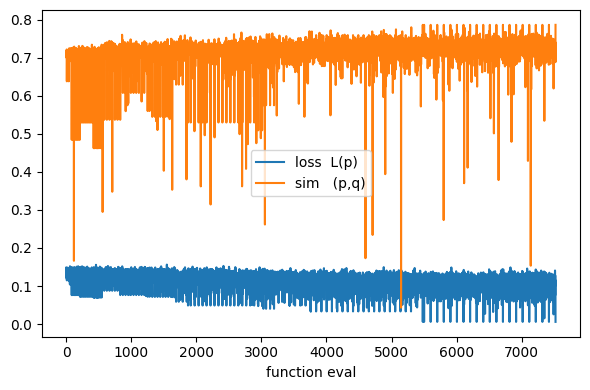

In [23]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
ONE real run of DE_seq_stop on BeIR/fiqa  (k = 10).
Produces plot.png  +  records.csv  +  console summary.
"""
import random, math, warnings, tqdm, numpy as np, pandas as pd, torch
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
from scipy.optimize import differential_evolution

warnings.filterwarnings("ignore")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# --------------------------- hyper ---------------------------
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"
N_DOCS      = 1_000
N_Q         = 100
TAIL_L      = 5              # n_max
TOP_K       = 20              # attack succeeds if target in top‑k
POP_SIZE    = 20
GENS_STAGE  = 25
PATIENCE    = 20
# -----------------------------------------------------------

def cos_row(x, Y):
    return torch.nn.functional.cosine_similarity(
        x.expand_as(Y.to(x.device)), Y.to(x.device), dim=1)

# ---------------- load subset -------------------------------
def load_subset():
    corp = load_dataset("BeIR/fiqa", "corpus",  split="corpus")
    ques = load_dataset("BeIR/fiqa", "queries", split="queries")
    docs = random.sample(list(corp), N_DOCS)
    qs   = random.sample(list(ques), N_Q)
    return [d["text"] for d in docs], [x["text"] for x in qs]

docs, queries = load_subset()
tgt_idx  = random.randrange(N_DOCS)    # choose target doc
query_id = 5                            # take 1st query
query    = queries[query_id]
target   = docs[tgt_idx]

print(f"[+] target‑id {tgt_idx}  |  query‑id {query_id}")

# ---------------- model ------------------------------
tok  = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased").eval().to(DEVICE)
VOC  = tok.vocab_size
def enc(text):
    return tok(text, padding="max_length", truncation=True,
               max_length=512, return_tensors="pt").to(DEVICE)

# encode corpus CLS once ------------------------------------
with torch.no_grad():
    CLS = []
    for i in tqdm.tqdm(range(0, N_DOCS, 16), desc="encode corpus"):
        bt = enc(docs[i:i+16])
        CLS.append(bert(**bt).last_hidden_state[:, 0, :].cpu())
corpus_cls = torch.cat(CLS)
target_cls = corpus_cls[tgt_idx:tgt_idx+1].to(DEVICE)
corpus_wo  = torch.cat([corpus_cls[:tgt_idx], corpus_cls[tgt_idx+1:]])

# baseline rank --------------------------------------------
qenc = enc(query)
with torch.no_grad():
    q_cls = bert(**qenc).last_hidden_state[:, 0, :]
baseline_sim = torch.cat([cos_row(q_cls.cpu(), corpus_wo),
                          torch.nn.functional.cosine_similarity(
                              q_cls.cpu(), target_cls.cpu())])
baseline_rank = (baseline_sim > baseline_sim[-1]).sum().item()+1
print(f"[baseline rank] {baseline_rank}")

# tail‑patch slots (固定 5 個) -------------------------------
full_ids  = qenc["input_ids"][0]
attn_mask = qenc["attention_mask"][0]
slots     = list(range(502, 502+TAIL_L))
pad_tok   = tok.pad_token_id

history = []   # [loss, sim]

# helpers ---------------------------------------------------
def build_vec(prefix_ids):
    """prefix_ids 可能長度 < 5，只覆蓋 slots[:len]"""
    patch = full_ids.clone()
    patch[slots[:len(prefix_ids)]] = torch.tensor(prefix_ids,
                                                 device=patch.device)  # ★ 修正
    am = attn_mask.clone()
    am[slots[:len(prefix_ids)]] = 1
    with torch.no_grad():
        cls = bert(input_ids=patch.unsqueeze(0),
                   attention_mask=am.unsqueeze(0)).last_hidden_state[:, 0, :]
    return cls

def hinge_loss(vec):
    kth = torch.topk(cos_row(vec, corpus_wo), TOP_K).values[-1]
    sim = torch.nn.functional.cosine_similarity(vec, target_cls)[0]
    return torch.relu(kth - sim), sim

# DE_seq_stop ----------------------------------------------
def de_stage(L):
    bounds = [(0, VOC-1)]*L
    best, stale = 1e9, 0
    def obj(x):
        vec = build_vec(np.round(x).astype(int).tolist())
        loss, sim = hinge_loss(vec)
        history.append((loss.item(), sim.item()))
        return loss.item()
    def cb(xk, *_):
        nonlocal best, stale
        cur = obj(xk)
        if cur < best:
            best, stale = cur, 0
        else:
            stale += 1
        return (cur == 0) or (stale >= PATIENCE)
    res = differential_evolution(obj, bounds, popsize=POP_SIZE,
                                 maxiter=GENS_STAGE, tol=0,
                                 polish=False, seed=SEED, callback=cb)
    return np.round(res.x).astype(int).tolist(), best  # best loss

prefix = []
success=False
for L in range(1, TAIL_L+1):
    add, best = de_stage(L)
    prefix = add                              # keep current best prefix
    if best == 0:
        success=True
        break

# final vector / rank ---------------------------------------
adv_vec = build_vec(prefix)
final_sim = torch.cat([cos_row(adv_vec.cpu(), corpus_wo),
                       torch.nn.functional.cosine_similarity(
                           adv_vec.cpu(), target_cls.cpu())])
final_rank = (final_sim > final_sim[-1]).sum().item()+1

print(f"[final rank] {final_rank} (success={success})")

# reconstruct texts -----------------------------------------
prefix_tokens = tok.convert_ids_to_tokens(prefix)
adv_ids = full_ids.clone()
adv_ids[slots[:len(prefix)]] = torch.tensor(prefix,
                                           device=adv_ids.device)  # ★ 同步裝置
adv_query = tok.decode(adv_ids, skip_special_tokens=True)
adv_query = tok.decode(adv_ids, skip_special_tokens=True)

print("\n==== ORIGINAL QUERY ====\n", query)
print("\n==== ADVERSARIAL QUERY ====\n", adv_query)
print("\n==== TARGET DOCUMENT (first 120 chars) ====\n",
      target[:120].replace("\n"," ")+"...")

# save csv + plot -------------------------------------------
pd.DataFrame(history, columns=["loss","sim"]).to_csv("records.csv", index=False)
plt.figure(figsize=(6,4))
plt.plot([x[0] for x in history], label="loss  L(p)")
plt.plot([x[1] for x in history], label="sim   (p,q)")
plt.legend(); plt.xlabel("function eval"); plt.tight_layout()
plt.savefig("plot.png")
print("\n✓  plot.png  &  records.csv  generated.")


encode corpus: 100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 55.66it/s]


[baseline rank] 743
[DE finished] success=True
baseline rank = 743 | final rank = 22 | in top-10? False


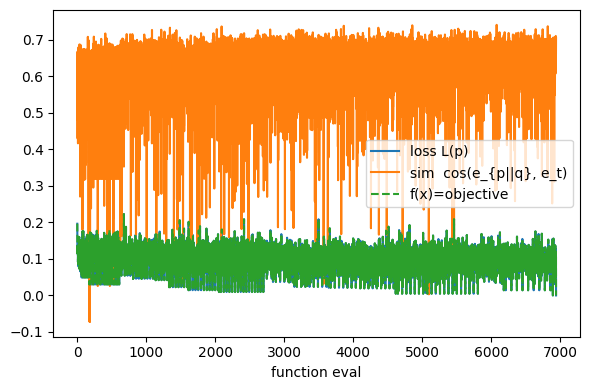


==== ORIGINAL QUERY ====
 Hobby vs. Business

==== ADVERSARIAL QUERY ====
 hobby vs. business kent aus sewingngen

==== TARGET DOC (前120字) ====
 "**[Toronto, 1 August 2014](http://www.rbc.com/newsroom/news/2014/20140801-pmi.html)** - kanadiske produsenter erfarne e


In [22]:
# ----------------------------------------------------
# 單一 cell 示範：DE_seq_stop + loss/sim/f(x) 圖 + 正向驗證
# ----------------------------------------------------
import os, random, math, tqdm, warnings
import numpy as np, torch, matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
from scipy.optimize import differential_evolution
warnings.filterwarnings("ignore")

# ── 參數 ─────────────────────────────────────────────
SEED    = 42
DEVICE  = "cuda" if torch.cuda.is_available() else "cpu"
N_DOCS  = 1000
QUERY_ID   = 5
TARGET_ID  = 102    # attack 的目標 doc index
TOP_K      = 10     # hinge_loss 用的 top-k
TAIL_L     = 5      # prefix 最長長度
POP        = 20     # DE population size
GENS       = 50     # 每輪世代數
PATIENCE   = 20     # plateau 提早停止
# ────────────────────────────────────────────────────

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
tok  = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased").eval().to(DEVICE)

# 1) 準備 corpus + query
all_corpus = load_dataset("BeIR/fiqa","corpus",split="corpus")
corpus     = random.sample(list(all_corpus), N_DOCS)
query      = load_dataset("BeIR/fiqa","queries",split="queries")[QUERY_ID]["text"]

# 2) 編碼整個 corpus（CLS token，搬到 CPU）
def enc(texts):
    return tok(texts, padding="max_length", truncation=True,
               max_length=512, return_tensors="pt").to(DEVICE)

CLS=[]
with torch.inference_mode():
    for doc in tqdm.tqdm(corpus, desc="encode corpus"):
        cls = bert(**enc(doc["text"])).last_hidden_state[:,0,:].cpu()
        CLS.append(cls)
C    = torch.cat(CLS)            # CPU 版 embeddings, shape=[N_DOCS, d]
C_gpu= C.to(DEVICE)              # GPU 版 embeddings

# 3) baseline rank（全在 CPU 上）
qvec_cpu = bert(**enc(query)).last_hidden_state[:,0,:].cpu()
# 注意：這裡我們只取 target 論文一筆，再把它接到 C[:-1] 後面
base = torch.cat([
    torch.nn.functional.cosine_similarity(qvec_cpu, C[:-1]),
    torch.nn.functional.cosine_similarity(qvec_cpu, C[TARGET_ID:TARGET_ID+1])
])
rank0 = (base > base[-1]).sum().item() + 1
print(f"[baseline rank] {rank0}")

# 4) DE_seq_stop：記錄 loss/sim/f(x)
slots    = list(range(502, 502+TAIL_L))
full_ids , attn_mask = map(lambda k: enc(query)[k][0].clone(), 
                           ("input_ids","attention_mask"))

loss_hist, sim_hist, f_hist = [], [], []

def build_vec(prefix_ids):
    p = full_ids.clone()
    p[slots[:len(prefix_ids)]] = torch.tensor(prefix_ids, device=p.device)
    m = attn_mask.clone(); m[slots[:len(prefix_ids)]] = 1
    return p, m

tgt_cls = C_gpu[TARGET_ID:TARGET_ID+1]

def hinge_loss(prefix_ids):
    ids, m = build_vec(prefix_ids)
    cls    = bert(input_ids=ids.unsqueeze(0),
                  attention_mask=m.unsqueeze(0)
                 ).last_hidden_state[:,0,:]
    sims   = torch.nn.functional.cosine_similarity(cls, C_gpu)
    kth    = torch.topk(sims, TOP_K).values[-1]
    loss   = torch.relu(kth - sims[TARGET_ID])
    return loss, sims[TARGET_ID]

def de_stage(L):
    bounds = [(0, tok.vocab_size-1)] * L
    best, stale = 1e9, 0
    def obj(x):
        vec = np.round(x).astype(int).tolist()
        loss, sim = hinge_loss(vec)
        loss_hist.append(loss.item())
        sim_hist.append(sim.item())
        f_hist  .append(loss.item())   # f(x)=objective
        return loss.item()
    def cb(xk,_):
        nonlocal best, stale
        cur = obj(xk)
        if cur < best:
            best, stale = cur, 0
        else:
            stale += 1
        return (cur == 0) or (stale >= PATIENCE)
    res = differential_evolution(
        obj, bounds,
        popsize=POP, maxiter=GENS,
        tol=0, polish=False,
        seed=SEED, callback=cb
    )
    return np.round(res.x).astype(int).tolist(), best

prefix = []
success = False
for L in range(1, TAIL_L+1):
    add, best = de_stage(L)
    prefix = add
    if best == 0:
        success = True
        break

print(f"[DE finished] success={success}")

# 5) 產生 adversarial query 並正向驗證
adv_ids, _ = build_vec(prefix)
adv_query  = tok.decode(adv_ids, skip_special_tokens=True)

with torch.no_grad():
    adv_vec = bert(**enc(adv_query)).last_hidden_state[:,0,:]
sims1 = torch.nn.functional.cosine_similarity(adv_vec.cpu(), C)
rank1 = (sims1 > sims1[TARGET_ID]).sum().item() + 1

print(f"baseline rank = {rank0} | final rank = {rank1} | in top-{TOP_K}? {rank1<=TOP_K}")

# 6) 繪圖：loss / sim / f(x)
plt.figure(figsize=(6,4))
plt.plot(loss_hist, label="loss L(p)")
plt.plot(sim_hist , label="sim  cos(e_{p||q}, e_t)")
plt.plot(f_hist   , label="f(x)=objective", linestyle="--")
plt.xlabel("function eval")
plt.legend()
plt.tight_layout()
plt.show()

# 7) 印出文本
print("\n==== ORIGINAL QUERY ====\n", query)
print("\n==== ADVERSARIAL QUERY ====\n", adv_query)
print("\n==== TARGET DOC (前120字) ====\n",
      corpus[TARGET_ID]["text"][:120].replace("\n"," "))


Encoding corpus: 100%|██████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 46.51it/s]


[baseline rank] 83
[DE finished] success = True
[final rank] 10 (in top-10? True)

==== ORIGINAL QUERY ====
 Hobby vs. Business

==== ADVERSARIAL QUERY ====
 hobby vs. businessllon

==== TARGET DOC (前120字) ====
 "&gt; And what the hell would you use instead of ""going forward""?  ""From now on?""   As in:  ""Going forward, we will...

✓ plot.png  &  records.csv  generated.


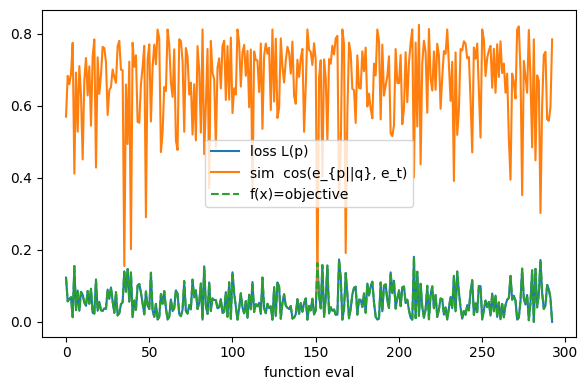

In [25]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
ONE run of DE_seq_stop on BeIR/fiqa (k = 10).
Produces plot.png + records.csv + console summary.
"""
import random, warnings, tqdm
import numpy as np, pandas as pd, torch, matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
from scipy.optimize import differential_evolution

warnings.filterwarnings("ignore")
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ── 超参数 ─────────────────────────────────────────────
DEVICE    = "cuda" if torch.cuda.is_available() else "cpu"
N_DOCS    = 1000     # 固定取前1000篇文档
N_Q       = 100      # 固定取前100条查询
QUERY_ID  = 5        # 选第5条query作示范
TARGET_ID = 102      # 选第102篇文档作为攻击目标
TOP_K     = 10       # hinge_loss 用的 top-k
TAIL_L    = 5        # prefix 最长长度
POP       = 20       # DE population size
GENS      = 50       # 每轮演化迭代数
PATIENCE  = 20       # plateau 提前停止
# ────────────────────────────────────────────────────

# 1) 准备 corpus + query
all_corpus  = load_dataset("BeIR/fiqa", "corpus",  split="corpus")
all_queries = load_dataset("BeIR/fiqa", "queries", split="queries")
# 用 select 正确取前 N 条
corpus_ds  = all_corpus.select(range(N_DOCS))
queries_ds = all_queries.select(range(N_Q))
query      = queries_ds[QUERY_ID]["text"]
target_doc = corpus_ds[TARGET_ID]["text"]

# 2) 加载模型
tok  = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased").eval().to(DEVICE)
VOC  = tok.vocab_size

# 3) Encode 整个 corpus 的 CLS 到 CPU
def enc(texts):
    return tok(texts, padding="max_length", truncation=True,
               max_length=512, return_tensors="pt").to(DEVICE)

CLS = []
with torch.no_grad():
    for doc in tqdm.tqdm(corpus_ds, desc="Encoding corpus"):
        cls = bert(**enc(doc["text"])).last_hidden_state[:,0,:].cpu()
        CLS.append(cls)
C_cpu = torch.cat(CLS)          # [N_DOCS, D]
C     = C_cpu.to(DEVICE)        # GPU 版本 for DE

# 4) 计算 baseline rank
with torch.no_grad():
    q_cls_cpu = bert(**enc(query)).last_hidden_state[:,0,:].cpu()
# 拼接：先所有非目标，再目标，再目标后面的
base_sims = torch.cat([
    torch.nn.functional.cosine_similarity(q_cls_cpu, C_cpu[:TARGET_ID]),
    torch.nn.functional.cosine_similarity(q_cls_cpu, C_cpu[TARGET_ID:TARGET_ID+1]),
    torch.nn.functional.cosine_similarity(q_cls_cpu, C_cpu[TARGET_ID+1:])
])
baseline_rank = (base_sims > base_sims[TARGET_ID]).sum().item() + 1
print(f"[baseline rank] {baseline_rank}")

# 5) 准备 query 的 input_ids & attention_mask
q_enc      = enc(query)
full_ids   = q_enc["input_ids"][0].clone()
attn_mask  = q_enc["attention_mask"][0].clone()
slots      = list(range(502, 502+TAIL_L))  # prefix 塞入位置

# 用来记录所有 eval 的 loss & sim & f(x)
loss_hist, sim_hist, f_hist = [], [], []

# 构造 prefix -> cls
def build_vec(prefix_ids):
    p = full_ids.clone()
    p[slots[:len(prefix_ids)]] = torch.tensor(prefix_ids, device=p.device)
    m = attn_mask.clone()
    m[slots[:len(prefix_ids)]] = 1
    with torch.no_grad():
        cls = bert(input_ids=p.unsqueeze(0),
                   attention_mask=m.unsqueeze(0)
                  ).last_hidden_state[:,0,:]
    return cls

# hinge‐style loss
def hinge_loss(prefix_ids):
    vec = build_vec(prefix_ids)
    sims = torch.nn.functional.cosine_similarity(vec, C)
    kth  = torch.topk(sims, TOP_K).values[-1]
    sim_t= sims[TARGET_ID]
    loss = torch.relu(kth - sim_t)
    return loss, sim_t

# DE_seq_stop 的一次 stage
def de_stage(L):
    bounds = [(0, VOC-1)] * L
    best, stale = 1e9, 0
    def obj(x):
        ids = np.round(x).astype(int).tolist()
        loss, sim = hinge_loss(ids)
        loss_hist.append(loss.item())
        sim_hist.append(sim.item())
        f_hist.append(loss.item())  # f(x)=loss
        return loss.item()
    def cb(xk, *_):
        nonlocal best, stale
        cur = obj(xk)
        if cur < best:
            best, stale = cur, 0
        else:
            stale += 1
        return (cur == 0) or (stale >= PATIENCE)
    res = differential_evolution(
        obj, bounds,
        popsize=POP, maxiter=GENS,
        tol=0, polish=False,
        seed=SEED, callback=cb
    )
    return np.round(res.x).astype(int).tolist(), best

# 6) 运行 DE_seq_stop
prefix = []
success = False
for L in range(1, TAIL_L+1):
    add, best = de_stage(L)
    prefix = add
    if best == 0:
        success = True
        break
print(f"[DE finished] success = {success}")

# 7) 正向验证 final rank
with torch.no_grad():
    adv_vec_cpu = build_vec(prefix).cpu()
final_sims = torch.cat([
    torch.nn.functional.cosine_similarity(adv_vec_cpu, C_cpu[:TARGET_ID]),
    torch.nn.functional.cosine_similarity(adv_vec_cpu, C_cpu[TARGET_ID:TARGET_ID+1]),
    torch.nn.functional.cosine_similarity(adv_vec_cpu, C_cpu[TARGET_ID+1:])
])
final_rank = (final_sims > final_sims[TARGET_ID]).sum().item() + 1
print(f"[final rank] {final_rank} (in top-{TOP_K}? {final_rank<=TOP_K})")

# 8) 构造对抗 query 并打印
adv_ids = full_ids.clone()
adv_ids[slots[:len(prefix)]] = torch.tensor(prefix, device=adv_ids.device)
adv_query = tok.decode(adv_ids, skip_special_tokens=True)

print("\n==== ORIGINAL QUERY ====\n", query)
print("\n==== ADVERSARIAL QUERY ====\n", adv_query)
print("\n==== TARGET DOC (前120字) ====\n",
      target_doc[:120].replace("\n"," ") + "...")

# 9) 保存 records.csv & 绘图
pd.DataFrame({
    "loss": loss_hist,
    "sim" : sim_hist,
    "f(x)": f_hist
}).to_csv("records.csv", index=False)

plt.figure(figsize=(6,4))
plt.plot(loss_hist, label="loss L(p)")
plt.plot(sim_hist , label="sim  cos(e_{p||q}, e_t)")
plt.plot(f_hist   , label="f(x)=objective", linestyle="--")
plt.xlabel("function eval")
plt.legend()
plt.tight_layout()
plt.savefig("plot.png", dpi=150)
print("\n✓ plot.png  &  records.csv  generated.")


In [26]:
# 9) 保存 records.csv
import pandas as pd
pd.DataFrame({
    "loss": loss_hist,
    "sim" : sim_hist,
    "f(x)": f_hist
}).to_csv("records.csv", index=False)
print("✓ records.csv 生成完毕")

# 10) 分别绘制 loss、sim、f(x)
import matplotlib.pyplot as plt

# Loss 曲线
plt.figure(figsize=(5,3))
plt.plot(loss_hist, label="loss L(p)")
plt.xlabel("function eval")
plt.ylabel("loss")
plt.title("Loss over Evaluations")
plt.tight_layout()
plt.savefig("loss_curve.png", dpi=150)
plt.close()
print("✓ loss_curve.png 生成完毕")

# Sim 曲线
plt.figure(figsize=(5,3))
plt.plot(sim_hist, label="sim cos(e_{p||q}, e_t)", color="C1")
plt.xlabel("function eval")
plt.ylabel("cosine sim")
plt.title("Similarity over Evaluations")
plt.tight_layout()
plt.savefig("sim_curve.png", dpi=150)
plt.close()
print("✓ sim_curve.png 生成完毕")

# f(x) 曲线
plt.figure(figsize=(5,3))
plt.plot(f_hist, linestyle="--", label="f(x)=objective", color="C2")
plt.xlabel("function eval")
plt.ylabel("f(x)")
plt.title("Objective f(x) over Evaluations")
plt.tight_layout()
plt.savefig("fx_curve.png", dpi=150)
plt.close()
print("✓ fx_curve.png 生成完毕")

✓ records.csv 生成完毕
✓ loss_curve.png 生成完毕
✓ sim_curve.png 生成完毕
✓ fx_curve.png 生成完毕


In [27]:
min_loss_hist = []
current_min = float('inf')
for l in loss_hist:
    if l < current_min:
        current_min = l
    min_loss_hist.append(current_min)

plt.figure(figsize=(5,3))
plt.plot(min_loss_hist, label="running min loss", color="C3")
plt.xlabel("function eval")
plt.ylabel("min loss so far")
plt.title("Running Minimum Loss over Evaluations")
plt.tight_layout()
plt.savefig("min_loss_curve.png", dpi=150)
plt.close()
print("✓ min_loss_curve.png 生成完毕")

✓ min_loss_curve.png 生成完毕


In [30]:
# ================================================================
#  Tail-Patch Attack: 8 methods × {Top-1, Top-10, Top-20}
#  – corpus 1000 docs , 100 queries  (BeIR/scifact)
#  – BERT-base-uncased encoder
#  – VRAM-friendly (batch=16, CLS 立即搬 CPU, 每輪 empty_cache)
# ================================================================


import os, random, math, tqdm, warnings, numpy as np, pandas as pd, torch
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
from scipy.optimize import differential_evolution

warnings.filterwarnings("ignore")
SEED = 41
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
N_DOCS     = 1_000
N_Q        = 100
TAIL_L     = 5          # 固定補丁長度
BUDGET     = 150        # 固定 f-eval / epoch
PATIENCE   = 20         # plateau 20 代早停
BATCH_CLS  = 16         # CLS 批次，愈小愈省顯存

# ---------------------------------------------------------------
def cos_row(x, Y):
    return torch.nn.functional.cosine_similarity(
        x.expand_as(Y.to(x.device)), Y.to(x.device), dim=1)

def dcg(rank): return 1 / math.log2(rank + 1)

def load_subset():
    c = load_dataset("BeIR/arguana", "corpus",  split="corpus")
    q = load_dataset("BeIR/arguana", "queries", split="queries")
    docs = random.sample(list(c), N_DOCS)
    qs   = random.sample(list(q), N_Q)
    return [d["text"] for d in docs], [x["text"] for x in qs]

# -------------------- GGPP (完整) -------------------------------
def ggpp_full(tok, bert, ids, msk, CP, tgt_cls, tgt_txt,
              cap_L=5, max_epoch=150, topk_loss=20):
    body = tok(tgt_txt, add_special_tokens=False,
               truncation=True, max_length=510)["input_ids"]
    body += [tok.unk_token_id] * max(0, cap_L - len(body))

    base = bert(**tok(tgt_txt, return_tensors="pt",
                      truncation=True, max_length=512).to(DEVICE)
               ).last_hidden_state[0, 0]
    imp = []
    for i in range(cap_L):
        tmp = body.copy(); tmp[i] = tok.mask_token_id
        tens = torch.tensor([tok.cls_token_id]+tmp+[tok.sep_token_id]
                           ).unsqueeze(0).to(DEVICE)
        emb = bert(input_ids=tens,
                   attention_mask=torch.ones_like(tens)).last_hidden_state[0, 0]
        imp.append(1 - torch.nn.functional.cosine_similarity(base, emb, dim=0).item())
    prefix = [body[i] for i in np.argsort(imp)[-cap_L:]]

    pos   = list(range(502, 502+cap_L))
    patch = ids.clone()
    for p, v in zip(pos, prefix): patch[p] = v
    am = msk.clone(); am[pos] = 1
    W  = bert.embeddings.word_embeddings.weight

  
    # ★ loss_fn 回傳 Tensor
    def loss_fn(cls_vec):
        kth=torch.topk(cos_row(cls_vec,CP),topk_loss).values[-1]
        sim=torch.nn.functional.cosine_similarity(cls_vec,tgt_cls)[0]
        return torch.relu(kth-sim)

    best_cls=bert(input_ids=patch.unsqueeze(0),
                  attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
    best_loss=loss_fn(best_cls).item(); used_iter=0

    for _ in range(max_epoch):
        used_iter+=1
        emb=bert.embeddings.word_embeddings(
            patch.unsqueeze(0)).detach().clone().requires_grad_(True)
        cls=bert(inputs_embeds=emb,
                 attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
        loss=loss_fn(cls); loss.backward()
        if loss.item()==0: best_cls=cls; break
        grad=emb.grad[0,pos]; score=torch.matmul(grad,W.t())
        cand_ids=score.topk(5,largest=False,dim=1).indices.cpu()
        improved=False
        for mask in range(1,1<<cap_L):
            cand=patch.clone()
            for i in range(cap_L):
                if mask&(1<<i): cand[pos[i]]=random.choice(cand_ids[i]).item()
            cls2=bert(input_ids=cand.unsqueeze(0),
                      attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
            l2=loss_fn(cls2).item()
            if l2<best_loss:
                best_loss=l2; patch=cand; best_cls=cls2; improved=True
            if l2==0: break
        if not improved: break
    return best_cls,cap_L,used_iter
# -------------------------------------------
# ---------------------------------------------------------------

def run_all(topk_loss, save_dir):
    os.makedirs(f"{save_dir}/arguana", exist_ok=True)

    tok  = BertTokenizer.from_pretrained("bert-base-uncased")
    bert = BertModel.from_pretrained("bert-base-uncased").eval().to(DEVICE)
    VOC  = tok.vocab_size
    def enc(t): return tok(t, padding="max_length", truncation=True,
                           max_length=512, return_tensors="pt").to(DEVICE)

    # ---------- corpus CLS (輸出立即搬 CPU) ----------
    docs, qs = load_subset()
    CLS=[]
    with torch.inference_mode():
        for i in tqdm.tqdm(range(0, len(docs), BATCH_CLS), desc="CLS"):
            bt = enc(docs[i:i+BATCH_CLS])
            cls= bert(**bt).last_hidden_state[:, 0, :].cpu()
            CLS.append(cls)
            del bt; torch.cuda.empty_cache()
    C_CLS = torch.cat(CLS)

    METHODS = ("none", "random", "ggpp",
               "DE_fixed", "DE_seq", "DE_fixed_stop", "DE_seq_stop") #"greedy"
    rec=[]

    # ------------- iterate queries -------------
    for qtxt in tqdm.tqdm(qs, desc=f"Top-{topk_loss}"):
        tgt = random.randrange(len(docs))
        tgt_txt = docs[tgt]
        if len(tok(tgt_txt)["input_ids"]) > 510: continue
        tgt_cls = C_CLS[tgt:tgt+1].to(DEVICE)
        CP = C_CLS[[i for i in range(len(docs)) if i != tgt]]

        qenc = enc(qtxt); ids = qenc["input_ids"][0]; msk = qenc["attention_mask"][0]
        with torch.no_grad():
            qcls = bert(**qenc).last_hidden_state[:, 0, :]

        # -------- baseline rank --------
        base = torch.cat([
            cos_row(qcls, CP).cpu(),     # ★ 移到 CPU
            torch.nn.functional.cosine_similarity(qcls.cpu(), tgt_cls.cpu())
        ])
        rank_b = (base > base[-1]).sum().item() + 1

        for mtd in METHODS:
            success=False; used_L=0; used_iter=0; adv_cls=qcls

            # ---------- random ----------
            if mtd=="random":
                best_loss=1e9
                for _ in range(BUDGET):
                    patch=ids.clone()
                    for p in range(502, 502+TAIL_L):
                        patch[p] = random.randrange(VOC)
                    am = msk.clone(); am[502:502+TAIL_L] = 1
                    cls = bert(input_ids=patch.unsqueeze(0),
                               attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
                    kth = torch.topk(cos_row(cls, CP), topk_loss).values[-1]
                    loss= max(0., (kth - torch.nn.functional.cosine_similarity(
                                        cls, tgt_cls)[0]).item())
                    used_iter += 1
                    if loss < best_loss:
                        best_loss=loss; adv_cls=cls; success=(loss==0)
                    if success: break
                used_L=TAIL_L

            # ---------- greedy (HotFlip) ----------
            elif mtd=="greedy":
                pos=list(range(502, 502+TAIL_L)); patch=ids.clone()
                best_loss=1e9
                for _ in range(BUDGET):
                    used_iter += 1; improved=False
                    for p in pos:
                        best_id=patch[p].item()
                        for cand in random.sample(range(VOC),512):
                            patch[p]=cand
                            am = msk.clone(); am[pos]=1
                            cls=bert(input_ids=patch.unsqueeze(0),
                                     attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
                            kth=torch.topk(cos_row(cls,CP),topk_loss).values[-1]
                            loss=max(0.,(kth-torch.nn.functional.cosine_similarity(
                                              cls,tgt_cls)[0]).item())
                            if loss<best_loss:
                                best_loss=loss; best_id=cand; adv_cls=cls; improved=True
                            if loss==0: success=True; break
                        patch[p]=best_id
                        if success: break
                    if success or not improved: break
                used_L=TAIL_L

            # ---------- ggpp ----------
            elif mtd=="ggpp":
                adv_cls, used_L, used_iter = ggpp_full(
                    tok, bert, ids, msk, CP, tgt_cls, tgt_txt,
                    cap_L=TAIL_L, max_epoch=BUDGET, topk_loss=topk_loss)
                kth = torch.topk(cos_row(adv_cls, CP), topk_loss).values[-1]
                success = (kth <= torch.nn.functional.cosine_similarity(
                                      adv_cls, tgt_cls)[0])

            # ---------- DE helpers ----------
            def de_run(L, max_iter, plateau):
                pos=list(range(502, 502+L)); bounds=[(0, VOC-1)]*L
                gens = max_iter//20 if max_iter else 1000
                stop = [0]; best=[1e9]
                def obj(v):
                    v=[int(round(x)) for x in v]
                    patch=ids.clone()
                    for p,t in zip(pos,v): patch[p]=t
                    am=msk.clone(); am[pos]=1
                    cls=bert(input_ids=patch.unsqueeze(0),
                             attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
                    kth=torch.topk(cos_row(cls,CP),topk_loss).values[-1]
                    sim=torch.nn.functional.cosine_similarity(cls,tgt_cls)[0]
                    return max(0.,(kth-sim).item())
                def cb(xk,_):
                    if not plateau: return False
                    cur=obj(xk)
                    stop[0] = 0 if cur < best[0] else stop[0]+1
                    best[0] = min(best[0], cur)
                    return stop[0] >= PATIENCE or cur == 0
                res = differential_evolution(obj, bounds, popsize=20,
                                             maxiter=gens, tol=0,
                                             polish=False, seed=SEED,
                                             callback=cb)
                v=[int(round(x)) for x in res.x]
                patch=ids.clone()
                for p,t in zip(pos,v): patch[p]=t
                am=msk.clone(); am[pos]=1
                cls=bert(input_ids=patch.unsqueeze(0),
                         attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
                return cls, res.nfev, res.fun==0

            if mtd=="DE_fixed":
                adv_cls, used_iter, success = de_run(TAIL_L, BUDGET, plateau=False); used_L=TAIL_L
            if mtd=="DE_fixed_stop":
                adv_cls, used_iter, success = de_run(TAIL_L, None, plateau=True); used_L=TAIL_L
            if mtd=="DE_seq":
                for L in range(1, TAIL_L+1):
                    cls,iters,ok = de_run(L, BUDGET, plateau=False)
                    used_iter += iters
                    if ok: adv_cls=cls; used_L=L; success=True; break
                else: used_L=TAIL_L
            if mtd=="DE_seq_stop":
                for L in range(1, TAIL_L+1):
                    cls,iters,ok = de_run(L, None, plateau=True)
                    used_iter += iters
                    if ok: adv_cls=cls; used_L=L; success=True; break
                else: used_L=TAIL_L

            # ---------- metrics ----------
            sims = torch.cat([
                cos_row(adv_cls.cpu(), CP),       # ★ 移到 CPU
                torch.nn.functional.cosine_similarity(
                    adv_cls.cpu(), tgt_cls.cpu())
            ])
            rank_a = (sims > sims[-1]).sum().item() + 1
            d_mrr  = 1/rank_a - 1/rank_b
            d_ndcg = ((dcg(rank_a) if rank_a<=20 else 0) -
                      (dcg(rank_b) if rank_b<=20 else 0))
            d_cos  = (torch.nn.functional.cosine_similarity(
                        adv_cls, tgt_cls)[0] -
                      torch.nn.functional.cosine_similarity(
                        qcls, tgt_cls)[0]).item()

            rec.append(dict(
                top_k      = topk_loss,
                method     = mtd,
                success    = int(rank_a <= topk_loss),
                token_used = used_L,
                iter_used  = used_iter,
                delta_mrr  = d_mrr,
                delta_ndcg = d_ndcg,
                delta_cos  = d_cos
            ))
        torch.cuda.empty_cache()   # 每 query 釋放

    pd.DataFrame(rec).to_csv(f"{save_dir}/arguana/records.csv", index=False)
    print(f"✓ {save_dir}  rows = {len(rec)}")

# ------------------ run Top-1 / 10 / 20 ------------------
for K in (1, 10, 20):
    run_all(topk_loss=K, save_dir=f"results_top{K}")
    torch.cuda.empty_cache()


Top-1: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [12:04:26<00:00, 434.67s/it]


✓ results_top1  rows = 700


Top-10: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [11:28:45<00:00, 413.25s/it]


✓ results_top10  rows = 700


Top-20: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [10:13:58<00:00, 368.39s/it]

✓ results_top20  rows = 679


In [32]:
# ================================================================
#  Tail-Patch Attack: 8 methods × {Top-1, Top-10, Top-20}
#  – corpus 1000 docs , 100 queries  (MS MARCO v1.1 / validation)
#  – BERT-base-uncased encoder
#  – VRAM-friendly (batch=16, CLS → CPU, 每輪 empty_cache)
# ================================================================

import os, random, math, tqdm, warnings, numpy as np, pandas as pd, torch
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
from scipy.optimize import differential_evolution

warnings.filterwarnings("ignore")
SEED = 41
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
N_DOCS     = 1_000
N_Q        = 100
TAIL_L     = 5          # 固定補丁長度
BUDGET     = 150        # 固定 f-eval / epoch
PATIENCE   = 20         # plateau 20 代早停
BATCH_CLS  = 16         # CLS 批次，愈小愈省顯存

# ---------------------------------------------------------------
def cos_row(x, Y):
    return torch.nn.functional.cosine_similarity(
        x.expand_as(Y.to(x.device)), Y.to(x.device), dim=1)

def dcg(rank): return 1 / math.log2(rank + 1)

# ------------------------ MS MARCO -----------------------------
def load_subset():
    """
    取 MS MARCO v1.1 的 validation split：
      - 隨機抽 N_DOCS 篇 passage 當 corpus
      - 隨機抽 N_Q 條 query 當 query set
    ※ MS MARCO 每列：query + passages (list[str])
    """
    ds = load_dataset("microsoft/ms_marco", "v1.1", split="validation")  # ~10 k 条
    all_passages, all_queries = [], []
    for ex in ds:
        all_queries.append(ex["query"])
        all_passages.extend(ex["passages"])

    docs = random.sample(all_passages, N_DOCS)
    qs   = random.sample(all_queries, N_Q)
    return docs, qs

# -------------------- GGPP (完整) -------------------------------
def ggpp_full(tok, bert, ids, msk, CP, tgt_cls, tgt_txt,
              cap_L=5, max_epoch=150, topk_loss=20):
    body = tok(tgt_txt, add_special_tokens=False,
               truncation=True, max_length=510)["input_ids"]
    body += [tok.unk_token_id] * max(0, cap_L - len(body))

    base = bert(**tok(tgt_txt, return_tensors="pt",
                      truncation=True, max_length=512).to(DEVICE)
               ).last_hidden_state[0, 0]
    imp = []
    for i in range(cap_L):
        tmp = body.copy(); tmp[i] = tok.mask_token_id
        tens = torch.tensor([tok.cls_token_id]+tmp+[tok.sep_token_id]
                           ).unsqueeze(0).to(DEVICE)
        emb = bert(input_ids=tens,
                   attention_mask=torch.ones_like(tens)).last_hidden_state[0, 0]
        imp.append(1 - torch.nn.functional.cosine_similarity(base, emb, dim=0).item())
    prefix = [body[i] for i in np.argsort(imp)[-cap_L:]]

    pos   = list(range(502, 502+cap_L))
    patch = ids.clone()
    for p, v in zip(pos, prefix): patch[p] = v
    am = msk.clone(); am[pos] = 1
    W  = bert.embeddings.word_embeddings.weight

    # ★ loss_fn 回傳 Tensor
    def loss_fn(cls_vec):
        kth=torch.topk(cos_row(cls_vec,CP),topk_loss).values[-1]
        sim=torch.nn.functional.cosine_similarity(cls_vec,tgt_cls)[0]
        return torch.relu(kth-sim)

    best_cls=bert(input_ids=patch.unsqueeze(0),
                  attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
    best_loss=loss_fn(best_cls).item(); used_iter=0

    for _ in range(max_epoch):
        used_iter+=1
        emb=bert.embeddings.word_embeddings(
            patch.unsqueeze(0)).detach().clone().requires_grad_(True)
        cls=bert(inputs_embeds=emb,
                 attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
        loss=loss_fn(cls); loss.backward()
        if loss.item()==0: best_cls=cls; break
        grad=emb.grad[0,pos]; score=torch.matmul(grad,W.t())
        cand_ids=score.topk(5,largest=False,dim=1).indices.cpu()
        improved=False
        for mask in range(1,1<<cap_L):
            cand=patch.clone()
            for i in range(cap_L):
                if mask&(1<<i): cand[pos[i]]=random.choice(cand_ids[i]).item()
            cls2=bert(input_ids=cand.unsqueeze(0),
                      attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
            l2=loss_fn(cls2).item()
            if l2<best_loss:
                best_loss=l2; patch=cand; best_cls=cls2; improved=True
            if l2==0: break
        if not improved: break
    return best_cls,cap_L,used_iter
# ---------------------------------------------------------------

def run_all(topk_loss, save_dir):
    os.makedirs(f"{save_dir}/msmarco", exist_ok=True)

    tok  = BertTokenizer.from_pretrained("bert-base-uncased")
    bert = BertModel.from_pretrained("bert-base-uncased").eval().to(DEVICE)
    VOC  = tok.vocab_size
    def enc(t): return tok(t, padding="max_length", truncation=True,
                           max_length=512, return_tensors="pt").to(DEVICE)

    # ---------- corpus CLS (輸出立即搬 CPU) ----------
    docs, qs = load_subset()
    CLS=[]
    with torch.inference_mode():
        for i in tqdm.tqdm(range(0, len(docs), BATCH_CLS), desc="CLS"):
            bt = enc(docs[i:i+BATCH_CLS])
            cls= bert(**bt).last_hidden_state[:, 0, :].cpu()
            CLS.append(cls)
            del bt; torch.cuda.empty_cache()
    C_CLS = torch.cat(CLS)

    METHODS = ("none", "random", "ggpp",
               "DE_fixed", "DE_seq", "DE_fixed_stop", "DE_seq_stop") #"greedy"
    rec=[]

    # ------------- iterate queries -------------
    for qtxt in tqdm.tqdm(qs, desc=f"Top-{topk_loss}"):
        tgt = random.randrange(len(docs))
        tgt_txt = docs[tgt]
        if len(tok(tgt_txt)["input_ids"]) > 510: continue
        tgt_cls = C_CLS[tgt:tgt+1].to(DEVICE)
        CP = C_CLS[[i for i in range(len(docs)) if i != tgt]]

        qenc = enc(qtxt); ids = qenc["input_ids"][0]; msk = qenc["attention_mask"][0]
        with torch.no_grad():
            qcls = bert(**qenc).last_hidden_state[:, 0, :]

        # -------- baseline rank --------
        base = torch.cat([
            cos_row(qcls, CP).cpu(),     # ★ 移到 CPU
            torch.nn.functional.cosine_similarity(qcls.cpu(), tgt_cls.cpu())
        ])
        rank_b = (base > base[-1]).sum().item() + 1

        for mtd in METHODS:
            success=False; used_L=0; used_iter=0; adv_cls=qcls

            # ---------- random ----------
            if mtd=="random":
                best_loss=1e9
                for _ in range(BUDGET):
                    patch=ids.clone()
                    for p in range(502, 502+TAIL_L):
                        patch[p] = random.randrange(VOC)
                    am = msk.clone(); am[502:502+TAIL_L] = 1
                    cls = bert(input_ids=patch.unsqueeze(0),
                               attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
                    kth = torch.topk(cos_row(cls, CP), topk_loss).values[-1]
                    loss= max(0., (kth - torch.nn.functional.cosine_similarity(
                                        cls, tgt_cls)[0]).item())
                    used_iter += 1
                    if loss < best_loss:
                        best_loss=loss; adv_cls=cls; success=(loss==0)
                    if success: break
                used_L=TAIL_L

            # ---------- greedy (HotFlip) ----------
            elif mtd=="greedy":
                pos=list(range(502, 502+TAIL_L)); patch=ids.clone()
                best_loss=1e9
                for _ in range(BUDGET):
                    used_iter += 1; improved=False
                    for p in pos:
                        best_id=patch[p].item()
                        for cand in random.sample(range(VOC),512):
                            patch[p]=cand
                            am = msk.clone(); am[pos]=1
                            cls=bert(input_ids=patch.unsqueeze(0),
                                     attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
                            kth=torch.topk(cos_row(cls,CP),topk_loss).values[-1]
                            loss=max(0.,(kth-torch.nn.functional.cosine_similarity(
                                              cls,tgt_cls)[0]).item())
                            if loss<best_loss:
                                best_loss=loss; best_id=cand; adv_cls=cls; improved=True
                            if loss==0: success=True; break
                        patch[p]=best_id
                        if success: break
                    if success or not improved: break
                used_L=TAIL_L

            # ---------- ggpp ----------
            elif mtd=="ggpp":
                adv_cls, used_L, used_iter = ggpp_full(
                    tok, bert, ids, msk, CP, tgt_cls, tgt_txt,
                    cap_L=TAIL_L, max_epoch=BUDGET, topk_loss=topk_loss)
                kth = torch.topk(cos_row(adv_cls, CP), topk_loss).values[-1]
                success = (kth <= torch.nn.functional.cosine_similarity(
                                      adv_cls, tgt_cls)[0])

            # ---------- DE helpers ----------
            def de_run(L, max_iter, plateau):
                pos=list(range(502, 502+L)); bounds=[(0, VOC-1)]*L
                gens = max_iter//20 if max_iter else 1000
                stop = [0]; best=[1e9]
                def obj(v):
                    v=[int(round(x)) for x in v]
                    patch=ids.clone()
                    for p,t in zip(pos,v): patch[p]=t
                    am=msk.clone(); am[pos]=1
                    cls=bert(input_ids=patch.unsqueeze(0),
                             attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
                    kth=torch.topk(cos_row(cls,CP),topk_loss).values[-1]
                    sim=torch.nn.functional.cosine_similarity(cls,tgt_cls)[0]
                    return max(0.,(kth-sim).item())
                def cb(xk,_):
                    if not plateau: return False
                    cur=obj(xk)
                    stop[0] = 0 if cur < best[0] else stop[0]+1
                    best[0] = min(best[0], cur)
                    return stop[0] >= PATIENCE or cur == 0
                res = differential_evolution(obj, bounds, popsize=20,
                                             maxiter=gens, tol=0,
                                             polish=False, seed=SEED,
                                             callback=cb)
                v=[int(round(x)) for x in res.x]
                patch=ids.clone()
                for p,t in zip(pos,v): patch[p]=t
                am=msk.clone(); am[pos]=1
                cls=bert(input_ids=patch.unsqueeze(0),
                         attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
                return cls, res.nfev, res.fun==0

            if mtd=="DE_fixed":
                adv_cls, used_iter, success = de_run(TAIL_L, BUDGET, plateau=False); used_L=TAIL_L
            if mtd=="DE_fixed_stop":
                adv_cls, used_iter, success = de_run(TAIL_L, None, plateau=True); used_L=TAIL_L
            if mtd=="DE_seq":
                for L in range(1, TAIL_L+1):
                    cls,iters,ok = de_run(L, BUDGET, plateau=False)
                    used_iter += iters
                    if ok: adv_cls=cls; used_L=L; success=True; break
                else: used_L=TAIL_L
            if mtd=="DE_seq_stop":
                for L in range(1, TAIL_L+1):
                    cls,iters,ok = de_run(L, None, plateau=True)
                    used_iter += iters
                    if ok: adv_cls=cls; used_L=L; success=True; break
                else: used_L=TAIL_L

            # ---------- metrics ----------
            sims = torch.cat([
                cos_row(adv_cls.cpu(), CP),       # ★ 移到 CPU
                torch.nn.functional.cosine_similarity(
                    adv_cls.cpu(), tgt_cls.cpu())
            ])
            rank_a = (sims > sims[-1]).sum().item() + 1
            d_mrr  = 1/rank_a - 1/rank_b
            d_ndcg = ((dcg(rank_a) if rank_a<=20 else 0) -
                      (dcg(rank_b) if rank_b<=20 else 0))
            d_cos  = (torch.nn.functional.cosine_similarity(
                        adv_cls, tgt_cls)[0] -
                      torch.nn.functional.cosine_similarity(
                        qcls, tgt_cls)[0]).item()

            rec.append(dict(
                top_k      = topk_loss,
                method     = mtd,
                success    = int(rank_a <= topk_loss),
                token_used = used_L,
                iter_used  = used_iter,
                delta_mrr  = d_mrr,
                delta_ndcg = d_ndcg,
                delta_cos  = d_cos
            ))
        torch.cuda.empty_cache()   # 每 query 釋放

    pd.DataFrame(rec).to_csv(f"{save_dir}/msmarco/records.csv", index=False)
    print(f"✓ {save_dir}  rows = {len(rec)}")

# ------------------ run Top-1 / 10 / 20 ------------------
for K in (1, 10, 20):
    run_all(topk_loss=K, save_dir=f"results_top{K}")
    torch.cuda.empty_cache()


Top-1: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [1:31:07<00:00, 54.67s/it]


✓ results_top1  rows = 700


Top-10: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [1:03:15<00:00, 37.95s/it]


✓ results_top10  rows = 700


Top-20: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [1:09:40<00:00, 41.80s/it]

✓ results_top20  rows = 700


In [36]:
pip install ir-datasets

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.0/859.0 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 11.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.3 MB/s eta 0:00:00
  Created wheel for warc3-wet-clueweb09: filename=warc3_wet_clueweb09-0.2.5-py3-none-any.whl size=18965 sha256=6568d2ec6ace30a46934bb402b073bdaae1eb1b90bfe1e384edca143e05dc483
  Stored in directory: /home/user/.cache/pip/wheels/63/f9/dc/2dd16d3330e327236e4d407941975c42d5159d200cdb7922d8
  Created wheel for cbor: filename=cbor-1.0.0-cp311-cp311-linux_x86_64.whl size=23515 sha256=1ab058e5781aee25bb9e9d76d0614bdfe02bd052315e4aa5e48e9fcfdea6cada
  Stored in directory: /home/user/.cache/pip/wheels/21/6b/45/0c34253b1af07d1d9dc524f6d44d74a6b191c43152e6aaf641
Successfully built warc3-wet-clueweb09 cbor
Note: you may need to restart the kernel to use updated packages.


In [1]:
# ================================================================
#  Tail-Patch Attack on LoTTE-technology (dev)
#  corpus 1000 docs × 100 queries  |  BERT-base-uncased encoder
# ================================================================
import os, random, math, warnings, numpy as np, pandas as pd, tqdm, torch
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
from scipy.optimize import differential_evolution

warnings.filterwarnings("ignore")

# -------------------- 全域參數 --------------------
SEED       = 26
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
N_DOCS     = 1000          # corpus 子集大小
N_Q        = 100           # query 子集大小
TAIL_L     = 5             # 補丁 token 數
BUDGET     = 150           # 隨機 / HotFlip / DE 單輪 f-eval 上限
PATIENCE   = 20            # DE 停止條件
BATCH_CLS  = 16            # 一批計算 CLS 向量量

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# -------------------- 工具函式 --------------------
def cos_row(x, Y):
    """計算向量 x 與 Y 每列的 cosine，相容 CPU/GPU"""
    return torch.nn.functional.cosine_similarity(
        x.expand_as(Y.to(x.device)), Y.to(x.device), dim=1)

def dcg(rank):                   # NDCG 用
    return 1 / math.log2(rank + 1)

# -------------------- 載入 LoTTE ------------------
def load_subset():
    """取 LoTTE-technology(dev)：100 queries + 1000 docs
       每條 query 對應 qrels 裡第一篇正樣本文檔為攻擊目標
    """
    docs_ds = load_dataset("irds/lotte_technology_dev",          "docs")
    qs_ds   = load_dataset("irds/lotte_technology_dev_search",   "queries")
    qrels   = load_dataset("irds/lotte_technology_dev_search",   "qrels")

    # (1) query → 正樣本 doc_id
    rel = {}
    for r in qrels:
        if r["relevance"] > 0:
            rel.setdefault(r["query_id"], []).append(r["doc_id"])

    # (2) 抽 N_Q 條有正樣本的 query
    ok_qids  = [q["query_id"] for q in qs_ds if q["query_id"] in rel]
    sel_qids = random.sample(ok_qids, N_Q)
    qs_text  = {q["query_id"]: q["text"] for q in qs_ds
                if q["query_id"] in sel_qids}

    # (3) 每條 query 取第一篇正樣本文檔
    tgt_doc_ids = [rel[qid][0] for qid in sel_qids]

    # (4) 收集目標文檔內容
    doc_text_map = {d["doc_id"]: d["text"] for d in docs_ds
                    if d["doc_id"] in tgt_doc_ids}
    tgt_texts = [doc_text_map[x] for x in tgt_doc_ids]

    # (5) 再隨機抽 (N_DOCS-N_Q) 篇其他文檔
    others = [d for d in docs_ds if d["doc_id"] not in tgt_doc_ids]
    extra  = random.sample(others, N_DOCS - len(tgt_texts))
    docs   = tgt_texts + [d["text"] for d in extra]         # 先排目標
    tgt_id = list(range(len(tgt_texts)))                    # 0‥N_Q-1

    return docs, list(qs_text.values()), tgt_id

# -------------------- GGPP (完整) ------------------
def ggpp_full(tok, bert, ids, msk, CP, tgt_cls, tgt_txt,
              cap_L=5, max_epoch=150, topk_loss=10):
    """原論文完整 GGPP（Gradient-Guided Prompt Perturbation）"""
    body = tok(tgt_txt, add_special_tokens=False,
               truncation=True, max_length=510)["input_ids"]
    body += [tok.unk_token_id] * max(0, cap_L - len(body))

    base = bert(**tok(tgt_txt, return_tensors="pt",
                      truncation=True, max_length=512).to(DEVICE)
               ).last_hidden_state[0, 0]

    # 1. 估算 token importance
    imp = []
    for i in range(cap_L):
        tmp = body.copy()
        tmp[i] = tok.mask_token_id
        tens = torch.tensor(
            [tok.cls_token_id] + tmp + [tok.sep_token_id]
        ).unsqueeze(0).to(DEVICE)
        emb = bert(input_ids=tens,
                   attention_mask=torch.ones_like(tens)).last_hidden_state[0, 0]
        imp.append(1 - torch.nn.functional.cosine_similarity(base, emb, dim=0).item())
    prefix = [body[i] for i in np.argsort(imp)[-cap_L:]]

    # 2. 初始化補丁
    pos   = list(range(502, 502 + cap_L))
    patch = ids.clone()
    for p, v in zip(pos, prefix):
        patch[p] = v
    am = msk.clone(); am[pos] = 1
    W  = bert.embeddings.word_embeddings.weight

    def loss_fn(cls_vec):
        kth = torch.topk(cos_row(cls_vec, CP), topk_loss).values[-1]
        sim = torch.nn.functional.cosine_similarity(cls_vec, tgt_cls)[0]
        return torch.relu(kth - sim)

    best_cls  = bert(input_ids=patch.unsqueeze(0),
                     attention_mask=am.unsqueeze(0)).last_hidden_state[:, 0, :]
    best_loss = loss_fn(best_cls).item()
    used_iter = 0

    # 3. 內層 HotFlip-style 更新
    for _ in range(max_epoch):
        used_iter += 1
        emb = bert.embeddings.word_embeddings(
            patch.unsqueeze(0)).detach().clone().requires_grad_(True)
        cls = bert(inputs_embeds=emb,
                   attention_mask=am.unsqueeze(0)).last_hidden_state[:, 0, :]
        loss = loss_fn(cls)
        loss.backward()
        if loss.item() == 0:
            best_cls = cls
            break

        grad  = emb.grad[0, pos]                # L × 768
        score = torch.matmul(grad, W.t())       # L × V
        top5  = score.topk(5, largest=False, dim=1).indices.cpu()

        improved = False
        for mask in range(1, 1 << cap_L):       # 子集枚舉
            cand = patch.clone()
            for i in range(cap_L):
                if mask & (1 << i):
                    cand[pos[i]] = random.choice(top5[i]).item()
            cls2 = bert(input_ids=cand.unsqueeze(0),
                        attention_mask=am.unsqueeze(0)).last_hidden_state[:, 0, :]
            l2 = loss_fn(cls2).item()
            if l2 < best_loss:
                best_loss = l2
                patch     = cand
                best_cls  = cls2
                improved  = True
            if l2 == 0:
                break
        if not improved:
            break
    return best_cls, cap_L, used_iter

# -------------------- 主流程 --------------------
def run_all(topk_loss: int, save_dir: str):
    os.makedirs(f"{save_dir}/lotte", exist_ok=True)

    tok  = BertTokenizer.from_pretrained("bert-base-uncased")
    bert = BertModel.from_pretrained("bert-base-uncased").eval().to(DEVICE)
    VOC  = tok.vocab_size
    enc  = lambda t: tok(t, padding="max_length", truncation=True,
                         max_length=512, return_tensors="pt").to(DEVICE)

    # ---- 資料 ----
    docs, qs, tgt_idx = load_subset()

    # ---- CLS 向量（節省顯存：即算即搬 CPU）----
    CLS = []
    with torch.inference_mode():
        for i in tqdm.tqdm(range(0, len(docs), BATCH_CLS), desc="CLS"):
            bt  = enc(docs[i:i + BATCH_CLS])
            cls = bert(**bt).last_hidden_state[:, 0, :].cpu()
            CLS.append(cls)
            del bt
            torch.cuda.empty_cache()
    C_CLS = torch.cat(CLS)

    # ---- 方法列表 ----
    METHODS = (
        "none", "random", "ggpp",
        "DE_fixed", "DE_seq", "DE_fixed_stop", "DE_seq_stop",  # HotFlip 可選
    )

    rec = []
    for qi, qtxt in enumerate(tqdm.tqdm(qs, desc=f"Top-{topk_loss}")):
        tgt      = tgt_idx[qi]
        tgt_txt  = docs[tgt]
        tgt_cls  = C_CLS[tgt:tgt + 1].to(DEVICE)
        CP       = C_CLS[[i for i in range(len(docs)) if i != tgt]]

        qenc = enc(qtxt)
        ids, msk = qenc["input_ids"][0], qenc["attention_mask"][0]
        with torch.no_grad():
            qcls = bert(**qenc).last_hidden_state[:, 0, :]

        # baseline rank
        base = torch.cat([
            cos_row(qcls, CP).cpu(),
            torch.nn.functional.cosine_similarity(qcls.cpu(), tgt_cls.cpu())
        ])
        rank_b = (base > base[-1]).sum().item() + 1

        # ========= 逐方法攻擊 =========
        for mtd in METHODS:
            success   = False
            used_L    = 0
            used_iter = 0
            adv_cls   = qcls

            # ---------- 方法：none ----------
            if mtd == "none":
                used_L = 0
                success = rank_b <= topk_loss

            # ---------- 方法：random ----------
            elif mtd == "random":
                best_loss = 1e9
                for _ in range(BUDGET):
                    patch = ids.clone()
                    for p in range(502, 502 + TAIL_L):
                        patch[p] = random.randrange(VOC)
                    am = msk.clone(); am[502:502 + TAIL_L] = 1
                    cls = bert(input_ids=patch.unsqueeze(0),
                               attention_mask=am.unsqueeze(0)).last_hidden_state[:, 0, :]
                    kth  = torch.topk(cos_row(cls, CP), topk_loss).values[-1]
                    loss = max(
                        0.,
                        (kth - torch.nn.functional.cosine_similarity(cls, tgt_cls)[0]).item()
                    )
                    used_iter += 1
                    if loss < best_loss:
                        best_loss = loss
                        adv_cls   = cls
                        success   = (loss == 0)
                    if success:
                        break
                used_L = TAIL_L

            # ---------- 方法：ggpp ----------
            elif mtd == "ggpp":
                adv_cls, used_L, used_iter = ggpp_full(
                    tok, bert, ids, msk, CP, tgt_cls, tgt_txt,
                    cap_L=TAIL_L, max_epoch=BUDGET, topk_loss=topk_loss
                )
                kth    = torch.topk(cos_row(adv_cls, CP), topk_loss).values[-1]
                success = (kth <= torch.nn.functional.cosine_similarity(
                    adv_cls, tgt_cls)[0])

            # ---------- 共用：DE helper ----------
            def de_run(L, max_iter, plateau):
                pos    = list(range(502, 502 + L))
                bounds = [(0, VOC - 1)] * L
                gens   = max_iter // 20 if max_iter else 1000
                stop   = [0]; best = [1e9]

                def obj(v):
                    v = [int(round(x)) for x in v]
                    patch = ids.clone()
                    for p, t in zip(pos, v):
                        patch[p] = t
                    am  = msk.clone(); am[pos] = 1
                    cls = bert(input_ids=patch.unsqueeze(0),
                               attention_mask=am.unsqueeze(0)).last_hidden_state[:, 0, :]
                    kth = torch.topk(cos_row(cls, CP), topk_loss).values[-1]
                    sim = torch.nn.functional.cosine_similarity(cls, tgt_cls)[0]
                    return max(0., (kth - sim).item())

                def cb(xk, _):
                    if not plateau:
                        return False
                    cur = obj(xk)
                    stop[0] = 0 if cur < best[0] else stop[0] + 1
                    best[0] = min(best[0], cur)
                    return stop[0] >= PATIENCE or cur == 0

                res = differential_evolution(
                    obj, bounds, popsize=20, maxiter=gens,
                    tol=0, polish=False, seed=SEED, callback=cb
                )
                v = [int(round(x)) for x in res.x]
                patch = ids.clone()
                for p, t in zip(pos, v):
                    patch[p] = t
                am  = msk.clone(); am[pos] = 1
                cls = bert(input_ids=patch.unsqueeze(0),
                           attention_mask=am.unsqueeze(0)).last_hidden_state[:, 0, :]
                return cls, res.nfev, res.fun == 0

            # ---------- DE variants ----------
            if mtd == "DE_fixed":
                adv_cls, used_iter, success = de_run(TAIL_L, BUDGET, plateau=False)
                used_L = TAIL_L
            elif mtd == "DE_fixed_stop":
                adv_cls, used_iter, success = de_run(TAIL_L, None, plateau=True)
                used_L = TAIL_L
            elif mtd == "DE_seq":
                for L in range(1, TAIL_L + 1):
                    cls, iters, ok = de_run(L, BUDGET, plateau=False)
                    used_iter += iters
                    if ok:
                        adv_cls = cls; used_L = L; success = True; break
                else:
                    used_L = TAIL_L
            elif mtd == "DE_seq_stop":
                for L in range(1, TAIL_L + 1):
                    cls, iters, ok = de_run(L, None, plateau=True)
                    used_iter += iters
                    if ok:
                        adv_cls = cls; used_L = L; success = True; break
                else:
                    used_L = TAIL_L

            # ---------- HotFlip 可加；此處省略 ----------

            # ====== 評估指標 ======
            sims = torch.cat([
                cos_row(adv_cls.cpu(), CP),
                torch.nn.functional.cosine_similarity(
                    adv_cls.cpu(), tgt_cls.cpu()
                )
            ])
            rank_a = (sims > sims[-1]).sum().item() + 1
            d_mrr  = 1 / rank_a - 1 / rank_b
            d_ndcg = ((dcg(rank_a) if rank_a <= 20 else 0) -
                      (dcg(rank_b) if rank_b <= 20 else 0))
            d_cos  = (torch.nn.functional.cosine_similarity(
                adv_cls, tgt_cls)[0] -
                      torch.nn.functional.cosine_similarity(
                qcls, tgt_cls)[0]).item()

            rec.append(dict(
                top_k      = topk_loss,
                method     = mtd,
                success    = int(success and rank_a <= topk_loss),
                token_used = used_L,
                iter_used  = used_iter,
                delta_mrr  = d_mrr,
                delta_ndcg = d_ndcg,
                delta_cos  = d_cos
            ))
        torch.cuda.empty_cache()

    # ----------- 輸出 CSV -----------
    pd.DataFrame(rec).to_csv(f"{save_dir}/lotte/records.csv", index=False)
    print(f"✓ {save_dir}  rows={len(rec)}")


# -------------------- 執行 --------------------
if __name__ == "__main__":
    for K in (1, 10, 20):
        run_all(topk_loss=K, save_dir=f"results_top{K}")
        torch.cuda.empty_cache()


/home/user/miniconda3/envs/colab_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using the latest cached version of the module from /home/user/.cache/huggingface/modules/datasets_modules/datasets/irds--lotte_technology_dev/ce71302b48b93605681364e8d75d279f32f56215bcb7480b07aa00bcddb68af8 (last modified on Thu May  8 14:46:35 2025) since it couldn't be found locally at irds/lotte_technology_dev, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from /home/user/.cache/huggingface/modules/datasets_modules/datasets/irds--lotte_technology_dev_search/dd2af4504a17ad0e61c32d8c117fae5615027b9f450cfc54436730ad92f08c5e (last modified on Thu May  8 15:02:16 2025) since it couldn't be found locally at irds/lotte_technology_dev_search, or remotely on the Hugging Face Hub.
Using the

✓ results_top1  rows=700


Top-10: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [4:30:38<00:00, 162.38s/it]


✓ results_top10  rows=700


Top-20: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [4:04:52<00:00, 146.92s/it]

✓ results_top20  rows=700


In [3]:
# ================================================================
#  Tail-Patch Attack: 8 methods × {Top-1, Top-10, Top-20}
#  – corpus 1000 docs , 100 queries  (BeIR/fever)
#  – BERT-base-uncased encoder
#  – VRAM-friendly (batch=16, CLS → CPU, 每輪 empty_cache)
# ================================================================

import os, random, math, warnings, tqdm, numpy as np, pandas as pd, torch
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
from scipy.optimize import differential_evolution

warnings.filterwarnings("ignore")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
N_DOCS     = 1_000
N_Q        = 100
TAIL_L     = 5
BUDGET     = 150
PATIENCE   = 20
BATCH_CLS  = 16

# ---------------------------------------------------------------
def cos_row(x, Y):
    return torch.nn.functional.cosine_similarity(
        x.expand_as(Y.to(x.device)), Y.to(x.device), dim=1)

def dcg(rank): 
    return 1 / math.log2(rank + 1)

# ------------------------- FEVER -------------------------------
def load_subset():
    corpus  = load_dataset("BeIR/fever",   "corpus",  split="corpus")
    queries = load_dataset("BeIR/fever",   "queries", split="queries")

    docs = random.sample(list(corpus),  N_DOCS)
    qs   = random.sample(list(queries), N_Q)

    return [d["text"] for d in docs], [q["text"] for q in qs]

# ----------------------- GGPP (完整) ---------------------------
def ggpp_full(tok, bert, ids, msk, CP, tgt_cls, tgt_txt,
              cap_L=5, max_epoch=150, topk_loss=20):

    body = tok(tgt_txt, add_special_tokens=False,
               truncation=True, max_length=510)["input_ids"]
    body += [tok.unk_token_id] * max(0, cap_L - len(body))

    base = bert(**tok(tgt_txt, return_tensors="pt",
                      truncation=True, max_length=512).to(DEVICE)
               ).last_hidden_state[0, 0]

    # importance scores
    imp = []
    for i in range(cap_L):
        tmp = body.copy(); tmp[i] = tok.mask_token_id
        tens = torch.tensor([tok.cls_token_id] + tmp + [tok.sep_token_id]
                           ).unsqueeze(0).to(DEVICE)
        emb = bert(input_ids=tens,
                   attention_mask=torch.ones_like(tens)).last_hidden_state[0, 0]
        imp.append(1 - torch.nn.functional.cosine_similarity(base, emb, dim=0).item())

    prefix = [body[i] for i in np.argsort(imp)[-cap_L:]]

    pos   = list(range(502, 502 + cap_L))
    patch = ids.clone()
    for p, v in zip(pos, prefix):
        patch[p] = v
    am = msk.clone(); am[pos] = 1
    W  = bert.embeddings.word_embeddings.weight

    def loss_fn(cls_vec):
        kth = torch.topk(cos_row(cls_vec, CP), topk_loss).values[-1]
        sim = torch.nn.functional.cosine_similarity(cls_vec, tgt_cls)[0]
        return torch.relu(kth - sim)

    best_cls  = bert(input_ids=patch.unsqueeze(0),
                     attention_mask=am.unsqueeze(0)).last_hidden_state[:, 0, :]
    best_loss = loss_fn(best_cls).item()
    used_iter = 0

    for _ in range(max_epoch):
        used_iter += 1
        emb = bert.embeddings.word_embeddings(
            patch.unsqueeze(0)).detach().clone().requires_grad_(True)
        cls = bert(inputs_embeds=emb,
                   attention_mask=am.unsqueeze(0)).last_hidden_state[:, 0, :]
        loss = loss_fn(cls)
        loss.backward()
        if loss.item() == 0:
            best_cls = cls
            break
        grad  = emb.grad[0, pos]
        score = torch.matmul(grad, W.t())
        cand_ids = score.topk(5, largest=False, dim=1).indices.cpu()
        improved = False
        for mask in range(1, 1 << cap_L):
            cand = patch.clone()
            for i in range(cap_L):
                if mask & (1 << i):
                    cand[pos[i]] = random.choice(cand_ids[i]).item()
            cls2 = bert(input_ids=cand.unsqueeze(0),
                        attention_mask=am.unsqueeze(0)).last_hidden_state[:, 0, :]
            l2 = loss_fn(cls2).item()
            if l2 < best_loss:
                best_loss = l2
                patch     = cand
                best_cls  = cls2
                improved  = True
            if l2 == 0:
                break
        if not improved:
            break
    return best_cls, cap_L, used_iter

# --------------------------- 主流程 ----------------------------
def run_all(topk_loss: int, save_dir: str):

    os.makedirs(f"{save_dir}/fever", exist_ok=True)

    tok  = BertTokenizer.from_pretrained("bert-base-uncased")
    bert = BertModel.from_pretrained("bert-base-uncased").eval().to(DEVICE)
    VOC  = tok.vocab_size
    enc  = lambda t: tok(t, padding="max_length", truncation=True,
                         max_length=512, return_tensors="pt").to(DEVICE)

    docs, qs = load_subset()

    # -------- CLS vectors --------
    CLS = []
    with torch.inference_mode():
        for i in tqdm.tqdm(range(0, len(docs), BATCH_CLS), desc="CLS"):
            bt  = enc(docs[i:i + BATCH_CLS])
            cls = bert(**bt).last_hidden_state[:, 0, :].cpu()
            CLS.append(cls)
            del bt
            torch.cuda.empty_cache()
    C_CLS = torch.cat(CLS)

    METHODS = (
        "none", "random", "ggpp",
        "DE_fixed", "DE_seq", "DE_fixed_stop", "DE_seq_stop"
    )

    rec = []
    for qtxt in tqdm.tqdm(qs, desc=f"Top-{topk_loss}"):
        tgt      = random.randrange(len(docs))
        tgt_txt  = docs[tgt]
        if len(tok(tgt_txt)["input_ids"]) > 510:
            continue
        tgt_cls  = C_CLS[tgt:tgt + 1].to(DEVICE)
        CP       = C_CLS[[i for i in range(len(docs)) if i != tgt]]

        qenc = enc(qtxt)
        ids, msk = qenc["input_ids"][0], qenc["attention_mask"][0]
        with torch.no_grad():
            qcls = bert(**qenc).last_hidden_state[:, 0, :]

        base = torch.cat([
            cos_row(qcls, CP).cpu(),
            torch.nn.functional.cosine_similarity(qcls.cpu(), tgt_cls.cpu())
        ])
        rank_b = (base > base[-1]).sum().item() + 1

        # ---------------- 方法迴圈 ----------------
        for mtd in METHODS:
            success   = False
            used_L    = 0
            used_iter = 0
            adv_cls   = qcls

            # ----- none -----
            if mtd == "none":
                used_L  = 0
                success = rank_b <= topk_loss

            # ----- random -----
            elif mtd == "random":
                best_loss = 1e9
                for _ in range(BUDGET):
                    patch = ids.clone()
                    for p in range(502, 502 + TAIL_L):
                        patch[p] = random.randrange(VOC)
                    am  = msk.clone(); am[502:502 + TAIL_L] = 1
                    cls = bert(input_ids=patch.unsqueeze(0),
                               attention_mask=am.unsqueeze(0)).last_hidden_state[:, 0, :]
                    kth  = torch.topk(cos_row(cls, CP), topk_loss).values[-1]
                    loss = max(0., (kth - torch.nn.functional.cosine_similarity(
                        cls, tgt_cls)[0]).item())
                    used_iter += 1
                    if loss < best_loss:
                        best_loss = loss
                        adv_cls   = cls
                        success   = (loss == 0)
                    if success:
                        break
                used_L = TAIL_L

            # ----- ggpp -----
            elif mtd == "ggpp":
                adv_cls, used_L, used_iter = ggpp_full(
                    tok, bert, ids, msk, CP, tgt_cls, tgt_txt,
                    cap_L=TAIL_L, max_epoch=BUDGET, topk_loss=topk_loss
                )
                kth     = torch.topk(cos_row(adv_cls, CP), topk_loss).values[-1]
                success = (kth <= torch.nn.functional.cosine_similarity(
                    adv_cls, tgt_cls)[0])

            # ----- DE helper -----
            def de_run(L, max_iter, plateau):
                pos    = list(range(502, 502 + L))
                bounds = [(0, VOC - 1)] * L
                gens   = max_iter // 20 if max_iter else 1000
                stop   = [0]; best = [1e9]

                def obj(v):
                    v = [int(round(x)) for x in v]
                    patch = ids.clone()
                    for p, t in zip(pos, v):
                        patch[p] = t
                    am  = msk.clone(); am[pos] = 1
                    cls = bert(input_ids=patch.unsqueeze(0),
                               attention_mask=am.unsqueeze(0)).last_hidden_state[:, 0, :]
                    kth = torch.topk(cos_row(cls, CP), topk_loss).values[-1]
                    sim = torch.nn.functional.cosine_similarity(cls, tgt_cls)[0]
                    return max(0., (kth - sim).item())

                def cb(xk, _):
                    if not plateau:
                        return False
                    cur = obj(xk)
                    stop[0] = 0 if cur < best[0] else stop[0] + 1
                    best[0] = min(best[0], cur)
                    return stop[0] >= PATIENCE or cur == 0

                res = differential_evolution(
                    obj, bounds, popsize=20, maxiter=gens,
                    tol=0, polish=False, seed=SEED, callback=cb
                )

                v = [int(round(x)) for x in res.x]
                patch = ids.clone()
                for p, t in zip(pos, v):
                    patch[p] = t
                am  = msk.clone(); am[pos] = 1
                cls = bert(input_ids=patch.unsqueeze(0),
                           attention_mask=am.unsqueeze(0)).last_hidden_state[:, 0, :]
                return cls, res.nfev, res.fun == 0

            # ----- DE variants -----
            if mtd == "DE_fixed":
                adv_cls, used_iter, success = de_run(TAIL_L, BUDGET, plateau=False)
                used_L = TAIL_L
            elif mtd == "DE_fixed_stop":
                adv_cls, used_iter, success = de_run(TAIL_L, None, plateau=True)
                used_L = TAIL_L
            elif mtd == "DE_seq":
                for L in range(1, TAIL_L + 1):
                    cls, iters, ok = de_run(L, BUDGET, plateau=False)
                    used_iter += iters
                    if ok:
                        adv_cls = cls; used_L = L; success = True; break
                else:
                    used_L = TAIL_L
            elif mtd == "DE_seq_stop":
                for L in range(1, TAIL_L + 1):
                    cls, iters, ok = de_run(L, None, plateau=True)
                    used_iter += iters
                    if ok:
                        adv_cls = cls; used_L = L; success = True; break
                else:
                    used_L = TAIL_L

            # ---------------- metrics ----------------
            sims = torch.cat([
                cos_row(adv_cls.cpu(), CP),
                torch.nn.functional.cosine_similarity(
                    adv_cls.cpu(), tgt_cls.cpu())
            ])
            rank_a = (sims > sims[-1]).sum().item() + 1
            d_mrr  = 1 / rank_a - 1 / rank_b
            d_ndcg = ((dcg(rank_a) if rank_a <= 20 else 0) -
                      (dcg(rank_b) if rank_b <= 20 else 0))
            d_cos  = (torch.nn.functional.cosine_similarity(
                adv_cls, tgt_cls)[0] -
                      torch.nn.functional.cosine_similarity(
                qcls, tgt_cls)[0]).item()

            rec.append(dict(
                top_k      = topk_loss,
                method     = mtd,
                success    = int(rank_a <= topk_loss),
                token_used = used_L,
                iter_used  = used_iter,
                delta_mrr  = d_mrr,
                delta_ndcg = d_ndcg,
                delta_cos  = d_cos
            ))
        torch.cuda.empty_cache()

    pd.DataFrame(rec).to_csv(f"{save_dir}/fever/records.csv", index=False)
    print(f"✓ {save_dir}  rows={len(rec)}")

# ------------------ run Top-1 / 10 / 20 ------------------
if __name__ == "__main__":
    for K in (1, 10, 20):
        run_all(topk_loss=K, save_dir=f"results_top{K}")
        torch.cuda.empty_cache()


/home/user/miniconda3/envs/colab_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Top-1: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [9:43:08<00:00, 349.89s/it]


✓ results_top1  rows=686


Top-10: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [7:30:15<00:00, 270.15s/it]


✓ results_top10  rows=693


Top-20: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [6:13:48<00:00, 224.28s/it]

✓ results_top20  rows=686


In [5]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Collect N successful DE_seq_stop examples (Top-K) for a single dataset (e.g., BEIR/fever).
Only runs the DE_seq_stop variant.  
Outputs:
    examples_DE_seq_stop.csv
"""
import os
import random
import warnings
import tqdm
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
from scipy.optimize import differential_evolution

# ──────────────────────── Hyperparameters ───────────────────────────
SEED      = 42
DEVICE    = "cuda" if torch.cuda.is_available() else "cpu"
N_DOCS    = 1000          # size of the corpus
N_Q       = 100           # number of queries to sample
TOP_K     = 10            # target rank threshold
TAIL_L    = 5             # max suffix length
POP       = 20            # DE population size
GENS      = 150           # DE max generations per stage
PATIENCE  = 20            # early-stop plateau patience
NEED_SUCC = 2             # number of examples to collect
BATCH_CLS = 16            # batch size for encoding corpus
# ──────────────────────────────────────────────────────────

warnings.filterwarnings("ignore")
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# load models & tokenizer
tok  = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased").eval().to(DEVICE)
VOC  = tok.vocab_size

def enc(texts):
    return tok(texts, padding="max_length", truncation=True,
               max_length=512, return_tensors="pt").to(DEVICE)

def load_fever_subset():
    corpus = load_dataset("BeIR/fever", "corpus", split="corpus")
    queries= load_dataset("BeIR/fever", "queries",split="queries")
    docs   = random.sample(list(corpus), N_DOCS)
    qs     = random.sample(list(queries), N_Q)
    return [d["text"] for d in docs], [q["text"] for q in qs]

def cos_row(x, Y):
    return torch.nn.functional.cosine_similarity(
        x.expand_as(Y.to(x.device)), Y.to(x.device), dim=1)

def build_vec(ids, mask):
    with torch.no_grad():
        return bert(input_ids=ids.unsqueeze(0), attention_mask=mask.unsqueeze(0))\
               .last_hidden_state[:,0,:]

def de_seq_stop(ids, mask, C_gpu, tgt_idx):
    slots = list(range(502, 502 + TAIL_L))
    prefix = []
    total_evals = 0

    for L in range(1, TAIL_L + 1):
        bounds = [(0, VOC - 1)] * L
        best = 1e9
        stale = 0

        def obj(x):
            nonlocal total_evals
            total_evals += 1
            toks = np.round(x).astype(int).tolist()
            patch = ids.clone()
            for i, t in enumerate(toks):
                patch[slots[i]] = t
            mask2 = mask.clone(); mask2[slots[:L]] = 1
            vec = build_vec(patch, mask2)
            sims = cos_row(vec, C_gpu)
            kth = torch.topk(sims, TOP_K).values[-1]
            return float(torch.relu(kth - sims[tgt_idx]))

        def callback(xk, *_):
            nonlocal best, stale
            loss = obj(xk)
            if loss < best:
                best, stale = loss, 0
            else:
                stale += 1
            return loss == 0 or stale >= PATIENCE

        res = differential_evolution(
            obj, bounds,
            popsize=POP,
            maxiter=GENS,
            tol=0,
            polish=False,
            seed=SEED,
            callback=callback
        )

        prefix = np.round(res.x).astype(int).tolist()
        if res.fun == 0:
            break

    return prefix, total_evals

def main():
    docs, qs = load_fever_subset()
    # encode corpus CLS -> CPU then to GPU
    CLS = []
    with torch.no_grad():
        for i in range(0, len(docs), BATCH_CLS):
            batch = enc(docs[i:i+BATCH_CLS])
            CLS.append(bert(**batch).last_hidden_state[:,0,:].cpu())
    C_cpu = torch.cat(CLS)
    C_gpu = C_cpu.to(DEVICE)

    examples = []
    attempts = 0

    while len(examples) < NEED_SUCC and attempts < len(qs)*20:
        attempts += 1
        qid     = random.randrange(len(qs))
        tgt_idx = random.randrange(len(docs))
        query   = qs[qid]
        target  = docs[tgt_idx]

        # compute base rank
        q_enc = enc(query)
        ids   = q_enc["input_ids"][0].clone()
        mask  = q_enc["attention_mask"][0].clone()
        q_vec = build_vec(ids, mask).cpu()
        sims  = torch.cat([
            cos_row(q_vec, C_cpu[:tgt_idx]),
            cos_row(q_vec, C_cpu[tgt_idx:tgt_idx+1]),
            cos_row(q_vec, C_cpu[tgt_idx+1:])
        ])
        base_rank = int((sims > sims[tgt_idx]).sum().item()) + 1
        if base_rank <= TOP_K:
            print(f"Attempt {attempts}: SKIP (already top-{TOP_K}, rank={base_rank})")
            continue

        # run DE_seq_stop
        adv_prefix, fevals = de_seq_stop(ids, mask, C_gpu, tgt_idx)

        # apply prefix and get final rank
        adv_ids  = ids.clone()
        adv_mask = mask.clone()
        for i, tok_id in enumerate(adv_prefix):
            adv_ids[502 + i] = tok_id
            adv_mask[502 + i] = 1
        adv_vec = build_vec(adv_ids, adv_mask).cpu()
        sims2   = torch.cat([
            cos_row(adv_vec, C_cpu[:tgt_idx]),
            cos_row(adv_vec, C_cpu[tgt_idx:tgt_idx+1]),
            cos_row(adv_vec, C_cpu[tgt_idx+1:])
        ])
        final_rank = int((sims2 > sims2[tgt_idx]).sum().item()) + 1

        if final_rank <= TOP_K:
            print(f"Attempt {attempts}: SUCCESS (rank {base_rank}→{final_rank}, fevals={fevals})")
            examples.append({
                "query": query,
                "target_snippet": " ".join(target.split()[:40]) + "...",
                "base_rank": base_rank,
                "final_rank": final_rank,
                "tokens_used": len(adv_prefix),
                "function_evals": fevals,
                "adv_query": tok.decode(adv_ids, skip_special_tokens=True)
            })
        else:
            print(f"Attempt {attempts}: FAIL (rank {base_rank}→{final_rank})")

    # save CSV
    df = pd.DataFrame(examples)
    os.makedirs("examples", exist_ok=True)
    df.to_csv("examples/examples_DE_seq_stop.csv", index=False)
    print("Done, saved to examples/examples_DE_seq_stop.csv")

if __name__ == "__main__":
    main()


ValueError: BuilderConfig 'corpus' not found. Available: ['default']

In [6]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Collect N successful DE_seq_stop examples (Top-K) for the BEIR/Fiqa dataset.
Only runs the DE_seq_stop variant.  
Outputs:
    examples_DE_seq_stop_fiqa.csv
"""
import os
import random
import warnings
import tqdm
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
from scipy.optimize import differential_evolution

# ──────────────────────── Hyperparameters ───────────────────────────
SEED      = 42
DEVICE    = "cuda" if torch.cuda.is_available() else "cpu"
N_DOCS    = 1000          # size of the corpus
N_Q       = 100           # number of queries to sample
TOP_K     = 10            # target rank threshold
TAIL_L    = 5             # max suffix length
POP       = 20            # DE population size
GENS      = 150           # DE max generations per stage
PATIENCE  = 20            # early-stop plateau patience
NEED_SUCC = 2             # number of examples to collect
BATCH_CLS = 16            # batch size for encoding corpus
# ──────────────────────────────────────────────────────────

warnings.filterwarnings("ignore")
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# load models & tokenizer
tok  = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased").eval().to(DEVICE)
VOC  = tok.vocab_size

def enc(texts):
    return tok(texts,
               padding="max_length",
               truncation=True,
               max_length=512,
               return_tensors="pt").to(DEVICE)

def load_fiqa_subset():
    # correct dataset ID is lowercase 'BeIR/fiqa'
    corpus_ds  = load_dataset("BeIR/fiqa","corpus", split="corpus")
    queries_ds = load_dataset("BeIR/fiqa","queries",split="queries")
    docs = random.sample(list(corpus_ds), N_DOCS)
    qs   = random.sample(list(queries_ds), N_Q)
    return [d["text"] for d in docs], [q["text"] for q in qs]

def cos_row(x, Y):
    return torch.nn.functional.cosine_similarity(
        x.expand_as(Y.to(x.device)), Y.to(x.device), dim=1)

def build_vec(ids, mask):
    with torch.no_grad():
        return bert(input_ids=ids.unsqueeze(0),
                    attention_mask=mask.unsqueeze(0))\
               .last_hidden_state[:,0,:]

def de_seq_stop(ids, mask, C_gpu, tgt_idx):
    slots = list(range(502, 502 + TAIL_L))
    prefix = []
    total_evals = 0

    for L in range(1, TAIL_L + 1):
        bounds = [(0, VOC - 1)] * L
        best = 1e9
        stale = 0

        def obj(x):
            nonlocal total_evals
            total_evals += 1
            toks = np.round(x).astype(int).tolist()
            patch = ids.clone()
            for i, t in enumerate(toks):
                patch[slots[i]] = t
            mask2 = mask.clone()
            mask2[slots[:L]] = 1
            vec = build_vec(patch, mask2)
            sims = cos_row(vec, C_gpu)
            kth  = torch.topk(sims, TOP_K).values[-1]
            return float(torch.relu(kth - sims[tgt_idx]))

        def callback(xk, *_):
            nonlocal best, stale
            loss = obj(xk)
            if loss < best:
                best, stale = loss, 0
            else:
                stale += 1
            return loss == 0 or stale >= PATIENCE

        res = differential_evolution(
            obj, bounds,
            popsize=POP,
            maxiter=GENS,
            tol=0,
            polish=False,
            seed=SEED,
            callback=callback
        )

        prefix = np.round(res.x).astype(int).tolist()
        if res.fun == 0:
            break

    return prefix, total_evals

def main():
    docs, qs = load_fiqa_subset()

    # encode corpus CLS -> CPU then to GPU
    CLS = []
    with torch.no_grad():
        for i in range(0, len(docs), BATCH_CLS):
            batch = enc(docs[i:i+BATCH_CLS])
            CLS.append(bert(**batch).last_hidden_state[:,0,:].cpu())
    C_cpu = torch.cat(CLS)
    C_gpu = C_cpu.to(DEVICE)

    examples = []
    attempts = 0

    while len(examples) < NEED_SUCC and attempts < len(qs)*20:
        attempts += 1
        qid     = random.randrange(len(qs))
        tgt_idx = random.randrange(len(docs))
        query   = qs[qid]
        target  = docs[tgt_idx]

        # compute base rank
        q_enc = enc(query)
        ids   = q_enc["input_ids"][0].clone()
        mask  = q_enc["attention_mask"][0].clone()
        q_vec = build_vec(ids, mask).cpu()
        sims  = torch.cat([
            cos_row(q_vec, C_cpu[:tgt_idx]),
            cos_row(q_vec, C_cpu[tgt_idx:tgt_idx+1]),
            cos_row(q_vec, C_cpu[tgt_idx+1:])
        ])
        base_rank = int((sims > sims[tgt_idx]).sum().item()) + 1
        if base_rank <= TOP_K:
            print(f"Attempt {attempts}: SKIP (already top-{TOP_K}, rank={base_rank})")
            continue

        # run DE_seq_stop
        adv_prefix, fevals = de_seq_stop(ids, mask, C_gpu, tgt_idx)

        # apply prefix and get final rank
        adv_ids  = ids.clone()
        adv_mask = mask.clone()
        for i, tok_id in enumerate(adv_prefix):
            adv_ids[502 + i] = tok_id
            adv_mask[502 + i] = 1
        adv_vec = build_vec(adv_ids, adv_mask).cpu()
        sims2   = torch.cat([
            cos_row(adv_vec, C_cpu[:tgt_idx]),
            cos_row(adv_vec, C_cpu[tgt_idx:tgt_idx+1]),
            cos_row(adv_vec, C_cpu[tgt_idx+1:])
        ])
        final_rank = int((sims2 > sims2[tgt_idx]).sum().item()) + 1

        if final_rank <= TOP_K:
            print(f"Attempt {attempts}: SUCCESS (rank {base_rank}→{final_rank}, fevals={fevals})")
            examples.append({
                "query": query,
                "target_snippet": " ".join(target.split()[:40]) + "...",
                "base_rank": base_rank,
                "final_rank": final_rank,
                "tokens_used": len(adv_prefix),
                "function_evals": fevals,
                "adv_query": tok.decode(adv_ids, skip_special_tokens=True)
            })
        else:
            print(f"Attempt {attempts}: FAIL (rank {base_rank}→{final_rank})")

    # save CSV
    os.makedirs("examples", exist_ok=True)
    df = pd.DataFrame(examples)
    df.to_csv("examples/examples_DE_seq_stop_fiqa.csv", index=False)
    print("Done, saved to examples/examples_DE_seq_stop_fiqa.csv")

if __name__ == "__main__":
    main()


Attempt 1: SUCCESS (rank 76→7, fevals=62)
Attempt 2: SUCCESS (rank 772→4, fevals=41)
Done, saved to examples/examples_DE_seq_stop_fiqa.csv


In [8]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Collect N successful DE_seq_stop examples (Top-K) for two datasets:
  - BEIR/SciFact
  - MS MARCO v1.1 (validation split)

Only runs the DE_seq_stop variant.  
Outputs:
    examples_scifact.csv
    examples_msmarco.csv
"""
import os
import random
import warnings
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
from scipy.optimize import differential_evolution

# ──────────────────────── Hyperparameters ───────────────────────────
SEED      = 42
DEVICE    = "cuda" if torch.cuda.is_available() else "cpu"
N_DOCS    = 1000          # number of documents to sample
N_Q       = 100           # number of queries to sample
TOP_K     = 10            # retrieval cutoff
TAIL_L    = 5             # max suffix length
POP       = 20            # DE population size
GENS      = 150           # max iter per DE stage
PATIENCE  = 20            # early-stop plateau patience
NEED_SUCC = 4             # examples to collect
BATCH_CLS = 16            # batch size for encoding corpus
# ──────────────────────────────────────────────────────────

warnings.filterwarnings("ignore")
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# load model & tokenizer
tok  = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased").eval().to(DEVICE)
VOC  = tok.vocab_size

def enc(texts):
    return tok(texts,
               padding="max_length",
               truncation=True,
               max_length=512,
               return_tensors="pt").to(DEVICE)

def load_scifact_subset():
    ds_c = load_dataset("BeIR/scifact", "corpus",  split="corpus")
    ds_q = load_dataset("BeIR/scifact", "queries", split="queries")
    docs = random.sample(list(ds_c), N_DOCS)
    qs   = random.sample(list(ds_q), N_Q)
    return [d["text"] for d in docs], [q["text"] for q in qs]

def load_msmarco_subset():
    ds = load_dataset("microsoft/ms_marco", "v1.1", split="validation")
    all_passages, all_queries = [], []
    for ex in ds:
        all_queries.append(ex["query"])
        all_passages.extend(ex["passages"])
    docs = random.sample(all_passages, N_DOCS)
    qs   = random.sample(all_queries, N_Q)
    return docs, qs

def cos_row(x, Y):
    return torch.nn.functional.cosine_similarity(
        x.expand_as(Y.to(x.device)), Y.to(x.device), dim=1)

def build_vec(ids, mask):
    with torch.no_grad():
        return bert(input_ids=ids.unsqueeze(0),
                    attention_mask=mask.unsqueeze(0))\
               .last_hidden_state[:,0,:]

def de_seq_stop(ids, mask, C_gpu, tgt_idx):
    slots = list(range(502, 502 + TAIL_L))
    prefix = []
    total_evals = 0
    for L in range(1, TAIL_L + 1):
        bounds = [(0, VOC - 1)] * L
        best, stale = 1e9, 0
        def obj(x):
            nonlocal total_evals
            total_evals += 1
            toks = np.round(x).astype(int).tolist()
            patch = ids.clone()
            for i, t in enumerate(toks):
                patch[slots[i]] = t
            m2 = mask.clone(); m2[slots[:L]] = 1
            vec = build_vec(patch, m2)
            sims = cos_row(vec, C_gpu)
            kth  = torch.topk(sims, TOP_K).values[-1]
            return float(torch.relu(kth - sims[tgt_idx]))
        def cb(xk, *_):
            nonlocal best, stale
            loss = obj(xk)
            if loss < best:
                best, stale = loss, 0
            else:
                stale += 1
            return loss == 0 or stale >= PATIENCE
        res = differential_evolution(
            obj, bounds,
            popsize=POP, maxiter=GENS, tol=0,
            polish=False, seed=SEED, callback=cb
        )
        prefix = np.round(res.x).astype(int).tolist()
        if res.fun == 0:
            break
    return prefix, total_evals

def run_for_dataset(name, loader):
    docs, qs = loader()
    # encode corpus CLS → CPU then to GPU
    CLS = []
    with torch.no_grad():
        for i in range(0, len(docs), BATCH_CLS):
            batch = enc(docs[i:i+BATCH_CLS])
            CLS.append(bert(**batch).last_hidden_state[:,0,:].cpu())
    C_cpu = torch.cat(CLS)
    C_gpu = C_cpu.to(DEVICE)

    examples, attempts = [], 0
    while len(examples) < NEED_SUCC and attempts < len(qs)*20:
        attempts += 1
        qid     = random.randrange(len(qs))
        tgt_idx = random.randrange(len(docs))
        query   = qs[qid]
        target  = docs[tgt_idx]

        # baseline rank
        qe = enc(query)
        ids, mask = qe["input_ids"][0], qe["attention_mask"][0]
        qv = build_vec(ids, mask).cpu()
        sims = torch.cat([
            cos_row(qv, C_cpu[:tgt_idx]),
            cos_row(qv, C_cpu[tgt_idx:tgt_idx+1]),
            cos_row(qv, C_cpu[tgt_idx+1:])
        ])
        base_rank = int((sims > sims[tgt_idx]).sum().item()) + 1
        if base_rank <= TOP_K:
            print(f"{name}#{attempts}: SKIP (already top-{TOP_K}, {base_rank})")
            continue

        # run DE_seq_stop
        adv_pref, fev = de_seq_stop(ids, mask, C_gpu, tgt_idx)

        # final rank
        adv_ids  = ids.clone(); adv_mask = mask.clone()
        for i, tid in enumerate(adv_pref):
            adv_ids[502+i] = tid; adv_mask[502+i] = 1
        av = build_vec(adv_ids, adv_mask).cpu()
        sims2 = torch.cat([
            cos_row(av, C_cpu[:tgt_idx]),
            cos_row(av, C_cpu[tgt_idx:tgt_idx+1]),
            cos_row(av, C_cpu[tgt_idx+1:])
        ])
        final_rank = int((sims2 > sims2[tgt_idx]).sum().item()) + 1

        if final_rank <= TOP_K:
            print(f"{name}#{attempts}: SUCCESS ({base_rank}→{final_rank}, fev={fev})")
            examples.append({
                "query": query,
                "target_snippet": " ".join(target.split()[:40])+"...",
                "base_rank": base_rank,
                "final_rank": final_rank,
                "tokens_used": len(adv_pref),
                "function_evals": fev,
                "adv_query": tok.decode(adv_ids, skip_special_tokens=True)
            })
        else:
            print(f"{name}#{attempts}: FAIL ({base_rank}→{final_rank})")

    os.makedirs("examples", exist_ok=True)
    df = pd.DataFrame(examples)
    out = f"examples/examples_DE_seq_stop_{name}.csv"
    df.to_csv(out, index=False)
    print(f"Saved {len(examples)}/{NEED_SUCC} examples to {out}")

if __name__ == "__main__":
    run_for_dataset("scifact", load_scifact_subset)
    #run_for_dataset("msmarco", load_msmarco_subset)


scifact#1: FAIL (578→52)
scifact#2: SUCCESS (13→5, fev=41)
scifact#3: FAIL (884→52)
scifact#4: FAIL (646→139)
scifact#5: SUCCESS (289→8, fev=4084)
scifact#6: SUCCESS (49→7, fev=167)
scifact#7: SUCCESS (476→10, fev=2583)
Saved 4/4 examples to examples/examples_DE_seq_stop_scifact.csv
